### Next step: (2/12)

1. Modify the code for assigning stimulus to each time bin
2. Don't use fixed time bins anymore, divide time length / 50 and round to nearest integer and then find time bin (different for each stimulus)
3. Retrain and recheck

### Libraries and dependencies

In [2]:
import os
import re
import copy
import time
import json
import umap
import random
import allensdk
import warnings
import colorsys
import numpy as np
from tqdm import tqdm
from scipy import stats
from skimage import data
from pathlib import Path
from hmmlearn import hmm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

c:\Users\jerry\anaconda3\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
output_dir = "C:/Users/Jerry/Downloads/vbn_s3_cache"
output_dir = Path(output_dir)
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

#session_id = 1049273528 # Day one of this mice
session_id = 1055403683
#session_id = 1044594870
#session_id = 1047977240 # To analyze different numbers of hidden states
#session_id = 1064644573 # Arbitrary pick

session = cache.get_ecephys_session(ecephys_session_id=session_id);
behavior_id = session.behavior_session_id;
behavior = cache.get_behavior_session(behavior_id);
sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block'] == 0]
units = session.get_units()
channels = session.get_channels()
spike_times = session.spike_times
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True)
unit_channels_filtered = unit_channels[(unit_channels.isi_violations < 0.5) &
                                      (unit_channels.presence_ratio > 0.9) &
                                      (unit_channels.amplitude_cutoff < 0.1) &
                                      (unit_channels.firing_rate > 0.1)]
unit_channels_indices = np.array(list(unit_channels_filtered[
    #(unit_channels_filtered['structure_acronym']=='VISp') |
    #(unit_channels_filtered['structure_acronym']=='VISpm') |
    #(unit_channels_filtered['structure_acronym']=='VISrl') |
    #(unit_channels_filtered['structure_acronym']=='VISl') |
    (unit_channels_filtered['structure_acronym']=='VISam') #|
    #(unit_channels_filtered['structure_acronym']=='VISal')
].index))
print(len(unit_channels_indices))

38


In [3]:
imgs = np.unique(sp['image_name'])
imgs = np.concatenate((imgs, np.array(['gray'])))

In [4]:
print(imgs)

['im005_r' 'im024_r' 'im034_r' 'im083_r' 'im087_r' 'im104_r' 'im111_r'
 'im114_r' 'omitted' 'gray']


### Helper Functions

In [4]:
# Obtain binned neuron spikings
# Start, stop are in seconds and bin_size is in ms
def getX(start, stop, bin_size):
    if (stop < 0 or start < 0): return -1
    time = stop - start
    bin_count = int(time * 1000 / bin_size)
    X = np.zeros(bin_count)
    for unit in tqdm(unit_channels_indices):
        # Dividing epochs
        raw_spikes = spike_times[unit]
        bins = np.linspace(start,stop,num=bin_count+1)
        x_1 = np.histogram(raw_spikes, bins=bins)[0].tolist()
        #x_1 = np.array(stats.zscore(x_1))
        X = np.vstack((X, x_1))
    X = np.delete(X, 0, 0)
    return X

# Plot a raster plot for binned neuron spikings
def raster(X):
    plt.figure(figsize=(20,10))
    raster_pos = {}
    for idx, row in enumerate(X):
        raster_pos[idx] = np.where(row==1)[0]
    raster_pos = raster_pos.values()
    plt.eventplot(raster_pos,linelengths=1,linewidths=1);

# Transform counts in each bin to only 1, randomly allocate 1 when no activities
def one_per_bin(X):
    X_1 = X.astype(bool).astype(int)
    for idx, bin in enumerate(X_1):
        if (np.sum(bin) > 1):
            new_bin = np.zeros(len(bin))
            random_neuron = np.random.choice(np.arange(0,len(bin)),1)
            new_bin[random_neuron] = 1
            X_1[idx] = new_bin
    return X_1

# Not used
def between_stimulus(session, trial_idx, bin_size, window):
    # Getting all the trials
    trials = session.trials
    # Only the ones that changed
    trials_change = trials[trials['is_change']]
    trial = trials_change.iloc[trial_idx]
    change_time = trial['change_time_no_display_delay']
    change_from = trial['initial_image_name']
    change_to = trial['change_image_name']

    # start and end in seconds
    start = change_time - window
    end = change_time + window
    X = getX(start, end, bin_size)
    x_axis = np.arange(- window * 1000, window * 1000+1, step=int(bin_size * 5))
    ticks = np.arange(0, 2 * window * 1000 + 1, step = int(bin_size * 5))
    return np.transpose(X), [change_from, change_to], x_axis, ticks

# Testing function to manually check prediction and stimulus
def display_stim(session):
    dictionary = {}
    trials = session.trials
    trials_idx = trials[(trials['start_time']>50) & (trials['stop_time']<650)].index
    for idx in trials_idx:
        trial = session.trials.loc[idx]
        change_from = trial['initial_image_name']
        change_to = trial['change_image_name']
        change_at = trial['change_time_no_display_delay']
        trial_start = trial['start_time']
        trial_end = trial['stop_time']
        if (change_from not in dictionary):
            dictionary[change_from] = 0
        dictionary[change_from] += 1
        if (change_to not in dictionary):
            dictionary[change_to] = 0
        dictionary[change_to] += 1
        #print('start: {}({}) |{}| {}({})'.format(change_from, trial_start, change_at, change_to,trial_end))
        if (len(list(dictionary.keys()))==8):
            continue
            #break
    return dictionary

# Obtaining histograms that shows the stimulus distribution for each hidden state
# Not used, use states_per_img() instead
def get_states_histogram(start, end, bin_size, predictions):
    sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block']==0]
    stimulus_presentation_id = 0
    is_change = sp.loc[0]['is_change']
    counts_unchanged = {}
    counts_hit = {}
    counts_miss = {}
    
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    unique_stimuli = np.append(np.unique(sp['image_name']), "gray")
    unique_preds = np.unique(predictions)

    all_states = {}
    for pred in unique_preds:
        all_states[pred] = 0
    for stimulus in unique_stimuli:
        counts_unchanged[stimulus] = copy.deepcopy(all_states)
    counts_hit = copy.deepcopy(counts_unchanged)
    counts_miss = copy.deepcopy(counts_unchanged)
        
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            stimulus_name = "gray"
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            is_change = sp.loc[stimulus_presentation_id]['is_change']
            if (bin_start_time < stimulus_start_time):
                stimulus_name = "gray"
            else:
                stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        else:
            stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
            
        if not is_change:
            counts_unchanged[stimulus_name][pred] += 1
        else:
            hit = sp.loc[stimulus_presentation_id]['rewarded']
            if hit:
                counts_hit[stimulus_name][pred] += 1
            else:
                counts_miss[stimulus_name][pred] += 1
    return counts_unchanged, counts_hit, counts_miss

# Updated version, not return ndarrays instead of dictionaries
# Tested, same results as states_per_img_no_first_dict()
def states_per_img_no_first(start, end, bin_size, preds, sp, lambdas):
    bin_size = bin_size / 1000
    lambdas_avg = np.mean(lambdas, axis=1)
    order = np.argsort(lambdas_avg)
    n_state = len(np.unique(preds))
    imgs = np.unique(sp['image_name'])
    u = np.zeros([len(imgs),n_state])
    h = np.zeros([len(imgs),n_state])
    m = np.zeros([len(imgs),n_state])
    g = np.zeros(n_state)
    stimulus_presentation_id=sp[sp['start_time'] <= start].index[-1]
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    first_hidden_state = True
    for idx, pred in enumerate(preds):
        bin_start_time = float(start + (bin_size) * idx)
        if bin_start_time > end:
            break
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        is_hit = sp.loc[stimulus_presentation_id]['rewarded']
        remapped_pred = np.where(order==pred)[0][0]
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            if not first_hidden_state:
                g[remapped_pred] += 1
                if (bin_start_time + bin_size > stimulus_start_time): # Next hidden state will be the first for an img
                    first_hidden_state = True
            else:
                first_hidden_state = False
            continue
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            first_hidden_state = False
            continue
        else:
            if first_hidden_state:
                first_hidden_state = False
                continue
            if not is_change:
                u[np.where(imgs==stimulus_name)[0][0]][remapped_pred] += 1
            else:
                if is_hit:
                    h[np.where(imgs==stimulus_name)[0][0]][remapped_pred] += 1
                else:
                    m[np.where(imgs==stimulus_name)[0][0]][remapped_pred] += 1
    return u, h, m, g

# Old version that returns dictionaries
# Kept for compatibility with other functions
def states_per_img_no_first_dict(start, end, bin_size, predictions, sp, lambdas):
    lambdas_avg = np.mean(lambdas, axis=1)
    order = np.argsort(lambdas_avg)
    # dictionary for each pred
    unique_preds = np.unique(predictions)
    states = {str(state): 0 for state in unique_preds}
    # dictionary for unchange, hit, miss
    unique_stimuli = np.unique(sp['image_name'])
    unchanged = {stimulus: copy.deepcopy(states) for stimulus in unique_stimuli}
    gray = copy.deepcopy(states)
    hit = copy.deepcopy(unchanged)
    miss = copy.deepcopy(unchanged)
    # The initial stimulus info
    stimulus_presentation_id=sp[sp['start_time'] <= start].index[-1]
    stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
    stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
    first_hidden_state = True 
    for idx, pred in enumerate(predictions):
        bin_start_time = float(start + (bin_size / 1000) * idx)
        if bin_start_time > end:
            break
        stimulus_name = sp.loc[stimulus_presentation_id]['image_name']
        is_change = sp.loc[stimulus_presentation_id]['is_change']
        is_hit = sp.loc[stimulus_presentation_id]['rewarded']
        remapped_pred = np.where(order==pred)[0][0]
        # Bin before stimulus: gray screen
        if (bin_start_time < stimulus_start_time):
            if not first_hidden_state:
                gray[str(remapped_pred)] += 1
                if (bin_start_time + bin_size / 1000 > stimulus_start_time): # Next hidden state will be the first for an img
                    #print("next: ", bin_start_time + bin_size / 1000, stimulus_start_time)
                    first_hidden_state = True
            else:
                first_hidden_state = False # Skipping
            continue
        # Bin after stimulus: gray screen, move to the next stimulus
        elif (bin_start_time > stimulus_end_time):
            #print("after: ", bin_start_time, stimulus_end_time)
            stimulus_presentation_id += 1
            stimulus_start_time = sp.loc[stimulus_presentation_id]['start_time']
            stimulus_end_time = sp.loc[stimulus_presentation_id]['end_time']
            first_hidden_state = False
            #gray[str(pred)] += 1 # Skipped because this is the first hidden state in gray screen
            continue
        else:
            if first_hidden_state:
                #print("img: ", bin_start_time, stimulus_start_time)
                first_hidden_state = False
                continue
            if not is_change:
                unchanged[stimulus_name][str(remapped_pred)] += 1
            else:
                if is_hit:
                    hit[stimulus_name][str(remapped_pred)] += 1
                else:
                    miss[stimulus_name][str(remapped_pred)] += 1
    return unchanged, hit, miss, gray

# Shows the hidden state distribution for each image stimulus and gray screen
def stimulus_state_dist(unchanged, hit, miss, gray):
    fig, axs = plt.subplots(len(unchanged)+1,3, figsize=(15,32))
    # Stimulus -> States
    for idx, each in enumerate(unchanged.keys()):
        states = list(unchanged[each].keys())
        unchanged_val = list(unchanged[each].values())
        unchanged_val = unchanged_val / np.sum(unchanged_val)
        axs[idx][0].bar(states, unchanged_val)
        axs[idx][0].set_title(str(each))
        axs[idx][0].set_yticks(np.arange(0,1.2,0.2))
        if (each == 'omitted'):
            continue

        hit_val = list(hit[each].values())
        hit_val = hit_val / np.sum(hit_val)
        axs[idx][1].bar(states, hit_val)
        axs[idx][1].set_title('hit')
        axs[idx][1].set_yticks(np.arange(0,1.2,0.2))

        miss_val = list(miss[each].values())
        miss_val = miss_val / np.sum(miss_val)
        axs[idx][2].bar(states, miss_val)
        axs[idx][2].set_title('miss')
        axs[idx][2].set_yticks(np.arange(0,1.2,0.2))
    states = list(gray.keys())
    gray_val = list(gray.values())
    gray_val = gray_val / np.sum(gray_val)
    axs[-1][0].bar(states, gray_val)
    axs[-1][0].set_title('gray')
    axs[-1][0].set_yticks(np.arange(0,1.2,0.2))

# Find and plot Euclidean distance across unchanged, hit, and miss trials
def stimulus_state_diff(unchanged, hit, miss, gray):
    # For each hidden state
    u = np.zeros(len(unchanged.keys()))
    h = copy.deepcopy(u)
    m = copy.deepcopy(u)
    gh = copy.deepcopy(u)
    gm = copy.deepcopy(u)
    gd = copy.deepcopy(u)
    hm = copy.deepcopy(u)
    for idx, stimulus in enumerate(unchanged.keys()):
        # Preprocess into ratios
        unchanged_each = list(unchanged[stimulus].values())
        unchanged_total = np.sum(unchanged_each) if np.sum(unchanged_each) > 0 else 1e-10
        unchanged_ratio = np.array(unchanged_each)/unchanged_total    
        hit_each = list(hit[stimulus].values())
        hit_total = np.sum(hit_each) if np.sum(hit_each) > 0 else 1e-10
        hit_ratio = np.array(hit_each)/hit_total
        miss_each = list(miss[stimulus].values())
        miss_total = np.sum(miss_each) if np.sum(miss_each) > 0 else 1e-10
        miss_ratio = np.array(miss_each)/miss_total
        gray_each = list(gray.values())
        gray_total = np.sum(gray_each) if np.sum(gray_each) > 0 else 1e-10
        gray_ratio = np.array(gray_each)/gray_total
        # Distance of baseline
        u[idx] = np.linalg.norm(unchanged_ratio)
        # Distance of hit w/ unchanged
        h[idx] = np.linalg.norm(unchanged_ratio - hit_ratio)
        # Distance of miss w/ unchanged
        m[idx] = np.linalg.norm(unchanged_ratio - miss_ratio)
        # Distance of hit w/ gray
        # gh[idx] = np.linalg.norm(gray_ratio - hit_ratio)
        # Distance of miss w/ gray
        # gm[idx] = np.linalg.norm(gray_ratio - miss_ratio)
        # Bar plot of difference between the two
        # gd[idx] = np.abs(gh[idx] - gm[idx])
        hm[idx] = np.linalg.norm(hit_ratio - miss_ratio)
        
    plt.figure(figsize=(20,10))
    #plt.plot(u, label='baseline')
    plt.plot(h, label='hit')
    plt.plot(m, label='miss')
#    plt.plot(gh, label='hit w/ gray')
#    plt.plot(gm, label='miss w/ gray')
    plt.plot(hm, label='hit w/ miss')
    plt.bar(np.arange(0,len(unchanged.keys())), gd, alpha=0.3)
    plt.xticks(ticks=np.arange(0,len(unchanged.keys())), labels=[str(each) for each in list(unchanged.keys())], label="diff between hit w/ gray and miss w/ gray")
    plt.legend()

# Get entropy using sklearn.stats.entropy with base 2, input a nested dictionary
def get_entropy(d):
    imgs = list(d.keys())
    try:
        imgs.remove('omitted')
    except:
        print("No Omitted")
    entropies = np.zeros(len(imgs))
    for idx, img in enumerate(imgs):
        values = np.array(list(d[img].values()))
        if np.sum(values) == 0:
            entropies[idx] = 5
            continue
        entropies[idx] = entropy(values, base=2)
    return entropies

def get_entropy_gray(gray):
    return entropy(np.array(list(gray.values())), base=2)

def generate_distinct_colors(n):
    colors = plt.cm.get_cmap('turbo', n)
    return [colors(i)[:3] for i in range(n)]
def visualize_prediction(start, end, target_start, target_end, bin_size, lambdas):
    bin_size /= 1000 # ms to s
    # Getting the closest time bins based on desired start and end time
    target_start_idx = int((target_start - start) / bin_size)
    target_start = start + bin_size * target_start_idx
    target_end_idx = int((target_end - start) / bin_size)
    target_end = start + bin_size * target_end_idx
    # Get the corresponding lambdas
    truncated_lambdas = lambdas[target_start_idx:target_end_idx]
    # Plot the states (lambdas)
    plt.figure(figsize=(40,20))
    plt.plot(np.arange(target_start, target_end-1e-5, bin_size), truncated_lambdas, ".-", mfc="orange");
    # Obtain the corresponding stimuli
    start_idx = list(sp[sp['start_time']>target_start].index)[0]
    end_idx = list(sp[sp['start_time']<target_end].index)[-1]
    unique_stimuli = np.unique(sp.loc[start_idx:end_idx]['image_name'])
    color = generate_distinct_colors(len(unique_stimuli))
    colors = {unique_stimuli[idx]: color[idx] for idx, each in enumerate(unique_stimuli)}
    labeled = {each: False for each in unique_stimuli} # Label stimulus color just once
    # Color based on each stimulus
    for i in range(start_idx, end_idx+1, 1):
        start_time = sp.loc[i]['start_time']
        end_time = sp.loc[i]['end_time']
        image_name = sp.loc[i]['image_name']
        if (sp.loc[i]['is_change']):
            print(sp.loc[i]['rewarded'])
        if not labeled[image_name]:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3, label=image_name)
            labeled[image_name] = True
        else:
            plt.axvspan(start_time, end_time, color=colors[image_name], alpha=0.3)
    plt.legend()

def similarity_archive(unchanged, hit, miss,gray, normalize, index, diff_matrix=None):
    fig, axs = plt.subplots(1,3, figsize=(27,9))
    imgs = list(unchanged.keys())
    imgs = np.concatenate((imgs, ['gray']))
    diff = np.array([np.zeros([len(imgs), len(imgs)])] * 3)
    collection = [unchanged, hit, miss]
    titles = ['unchanged', 'hit', 'miss']
    if diff_matrix is None:
        for idx, img in enumerate(imgs):
            for jdx, img_2 in enumerate(imgs):
                for kdx, ax in enumerate(axs):
                    if (img == 'gray'):
                        img1 = np.array(list(gray.values()))
                    else:
                        img1 = np.array(list(collection[kdx][img].values()))
                    img1 = img1 / np.sum(img1)
                    if (img_2 == 'gray'):
                        img2 = np.array(list(gray.values()))
                    else:
                        img2 = np.array(list(collection[kdx][img_2].values()))
                    img2 = img2 / np.sum(img2)
                    diff[kdx][idx][jdx] = np.linalg.norm(img1 - img2)
    else:
        diff = diff_matrix
    for idx, ax in enumerate(axs):
        if normalize:
            diff[idx] = diff[idx] / np.sum(diff[idx])
        ax.imshow(diff[idx])
        ax.set_title(titles[idx])
        ax.set_xticks(np.arange(0,10))
        ax.set_xticklabels(imgs)
        ax.set_yticks(np.arange(0,10))
        ax.set_yticklabels(imgs)
        for jdx in range(len(imgs)):
            for kdx in range(len(imgs)):
                ax.text(jdx, kdx, np.round(diff[idx][jdx][kdx], decimals=5), ha="center", va="center", color="w")
    
    path = 'C:/Users/jerry/Downloads/HMM_diff_pics' + str(session_id) + '_' + str(index) + '.png'
    plt.savefig(path)
    return diff

def similarity_dict(unchanged, hit, miss, gray, imgs):
    diff = np.array([np.zeros([len(imgs), len(imgs)])] * 3)
    collection = [unchanged, hit, miss]
    titles = ['unchanged', 'hit', 'miss']
    for idx, img_1 in enumerate(imgs):
        for jdx, img_2 in enumerate(imgs):
            for kdx in range(3):
                if (img_1 == 'gray'):
                    img1 = np.array(list(gray.values()))
                else:
                    img1 = np.array(list(collection[kdx][img_1].values()))
                img1 = img1 / np.sum(img1) if np.sum(img1)!=0 else 0
                if (img_2 == 'gray'):
                    img2 = np.array(list(gray.values()))
                else:
                    img2 = np.array(list(collection[kdx][img_2].values()))
                img2 = img2 / np.sum(img2) if np.sum(img2)!=0 else 0
                diff[kdx][idx][jdx] = np.linalg.norm(img1 - img2)
    diff[0] = diff[0] / np.sum(diff[0])
    diff[1] = diff[1] / np.sum(diff[1])
    diff[2] = diff[2] / np.sum(diff[2])
    return diff


def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def normalize(array):
    sum = np.sum(array) if np.sum(array) != 0 else 1e-10
    return np.array(array) / sum

# Updated, now take in ndarrays instead of dictionaries
def similarity(unchanged, hit, miss, gray, imgs):
    diff = np.array([np.zeros([len(imgs), len(imgs)])] * 3)
    unchanged = np.vstack((unchanged, gray))
    hit = np.vstack((hit, gray))
    miss = np.vstack((miss, gray))
    for idx in range(len(imgs)):
        u_1 = normalize(unchanged[idx])
        h_1 = normalize(hit[idx])
        m_1 = normalize(miss[idx])
        for jdx in range(len(imgs)):
            u_2 = normalize(unchanged[jdx])
            h_2 = normalize(hit[jdx])
            m_2 = normalize(miss[jdx])
            diff[0][idx][jdx] = np.linalg.norm(u_1-u_2)
            diff[1][idx][jdx] = np.linalg.norm(h_1-h_2)
            diff[2][idx][jdx] = np.linalg.norm(m_1-m_2)
    diff[0] = diff[0] / np.sum(diff[0])
    diff[1] = diff[1] / np.sum(diff[1])
    diff[2] = diff[2] / np.sum(diff[2])
    return diff

def visualize_3D(u_transformed, h_transformed, m_transformed, n_session, n_iters, colors, n_stimulus):
    marks = ["o", "x", "s", "p", "P", "*", "h", "H", "+", "X"]
    fig = plt.figure(figsize=(24,8))
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0,0], projection='3d')
    ax2 = fig.add_subplot(gs[0,1], projection='3d')
    ax3 = fig.add_subplot(gs[0,2], projection='3d')
    for i in range(n_session):
        for j in range(n_iters):
            for k in range(n_stimulus):
                index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
                ax1.scatter(u_transformed[index, 0], u_transformed[index, 1],u_transformed[index, 2], c=colors[k])
    
    n_stimulus -= 2
    for i in range(n_session):
        
        if (i == 10):
            break
        for j in range(n_iters):
            for k in range(n_stimulus):
                index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
                ax2.scatter(h_transformed[index, 0], h_transformed[index, 1],h_transformed[index, 2], c=colors[k],marker=marks[i])
                ax3.scatter(m_transformed[index, 0], m_transformed[index, 1],m_transformed[index, 2], c=colors[k],marker=marks[i])
    ax1.set_title("Unchanged")
    ax2.set_title("Hit")
    ax3.set_title("Miss")
    plt.legend(imgs);
    plt.show();

def get_data_points(arr, folder_name, dim):
    session_ids = np.sort(arr)
    length = len(session_ids)
    all_u = np.zeros(dim)
    all_h = np.zeros(dim)
    all_m = np.zeros(dim)
    all_g = np.zeros(dim)
    for session_id in tqdm(session_ids):
        for idx, n in enumerate(range(5)):
            path = "C:/Users/jerry/Downloads/" + str(folder_name) + "/" + str(session_id) + "_" + str(n) + ".npz"
            try:
                s = np.load(path, allow_pickle=True)
            except FileNotFoundError:
                print("Not found")
                continue
            u = s['u']
            h = s['h']
            m = s['m']
            g = s['g']

            u = np.vstack((u, g))
            norm = np.sum(u, axis=1, keepdims=True) + 1e-10
            u_norm = u / norm
            all_u = np.vstack((all_u, u_norm))
            
            h = np.delete(h, -1, 0)
            norm = np.sum(h, axis=1, keepdims=True) + 1e-10
            h_norm = h / norm
            all_h = np.vstack((all_h, h_norm))
            
            m = np.delete(m, -1, 0)
            norm = np.sum(m, axis=1, keepdims=True) + 1e-10
            m_norm = m / norm
            all_m = np.vstack((all_m, m_norm))
            
            norm = np.sum(g)
            all_g = np.vstack((all_g, g/norm))

    all_u = np.delete(all_u, 0, 0)
    all_h = np.delete(all_h, 0, 0)
    all_m = np.delete(all_m, 0, 0)
    all_g = np.delete(all_g, 0, 0)
    return all_u, all_h, all_m, all_g, length

def transform_UMAP(u, h, m, neighbor = 100, dist = 1, sprd = 1, comp = 3):
    umap_3d = umap.UMAP(n_neighbors=neighbor, min_dist=dist, spread= sprd, n_components=comp, n_jobs=1, random_state=0)
    u_transformed = umap_3d.fit_transform(u)
    h_transformed = umap_3d.fit_transform(h)
    m_transformed = umap_3d.fit_transform(m)
    return u_transformed, h_transformed, m_transformed

def UMAP_from_local(arr, folder_name, dim, n_iters, color, neighbor, dist, sprd, comp, n_stimulus):
    u, h, m, g, l = get_data_points(arr, folder_name, dim)
    u_t, h_t, m_t = transform_UMAP(u, h, m, neighbor, dist, sprd, comp)
    visualize_3D(u_t, h_t, m_t, l, n_iters, color, n_stimulus)

def transform_PCA(u, h, m, neighbor = 100, comp = 3):
    pca = PCA(n_components=comp)
    u_transformed = pca.fit_transform(u)
    h_transformed = pca.fit_transform(h)
    m_transformed = pca.fit_transform(m)
    return u_transformed, h_transformed, m_transformed

def PCA_from_local(arr, folder_name, dim, n_iters, color, neighbor, comp, n_stimulus):
    u, h, m, g, l = get_data_points(arr, folder_name, dim)
    u_t, h_t, m_t = transform_PCA(u, h, m, neighbor, comp)
    visualize_3D(u_t, h_t, m_t, l, n_iters, color, n_stimulus)


#def diff_from_local(arr, folder_name, dim, n_iters, color, neighbor, comp, n_stimulus):


### Model Selection with AIC/BIC

In [ ]:
X_train = np.transpose(getX(50,3550,50))
# train on the entire dataset
iters = 1
ns = np.arange(4,404,100)
aic = np.zeros([len(ns),iters])
bic = np.zeros([len(ns),iters])
ll =  np.zeros([len(ns),iters])
for idx, n in tqdm(enumerate(ns)):
    for i in range(iters):
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, verbose=True, tol=10)
        model.fit(X_train)
        aic[idx][i] = model.aic(X_train)
        bic[idx][i] = model.bic(X_train)
        ll[idx][i] = model.score(X_train)
fig, ax = plt.subplots()
ln1 = ax.plot(ns, np.mean(aic,axis=1), color='blue', label="AIC")
ln2 = ax.plot(ns, np.mean(bic,axis=1), color='red', label="BIC")
ax.legend()
ax2 = ax.twinx()
ln3 = ax2.plot(ns, np.mean(ll,axis=1), color='green', label="LL")
ax.set_ylabel("AIC/BIC")
ax2.set_ylabel("Log likelihood")
ax.set_xlabel("Number of Components")
ax2.legend()
fig.tight_layout()
plt.show()

### To make sure HMM works

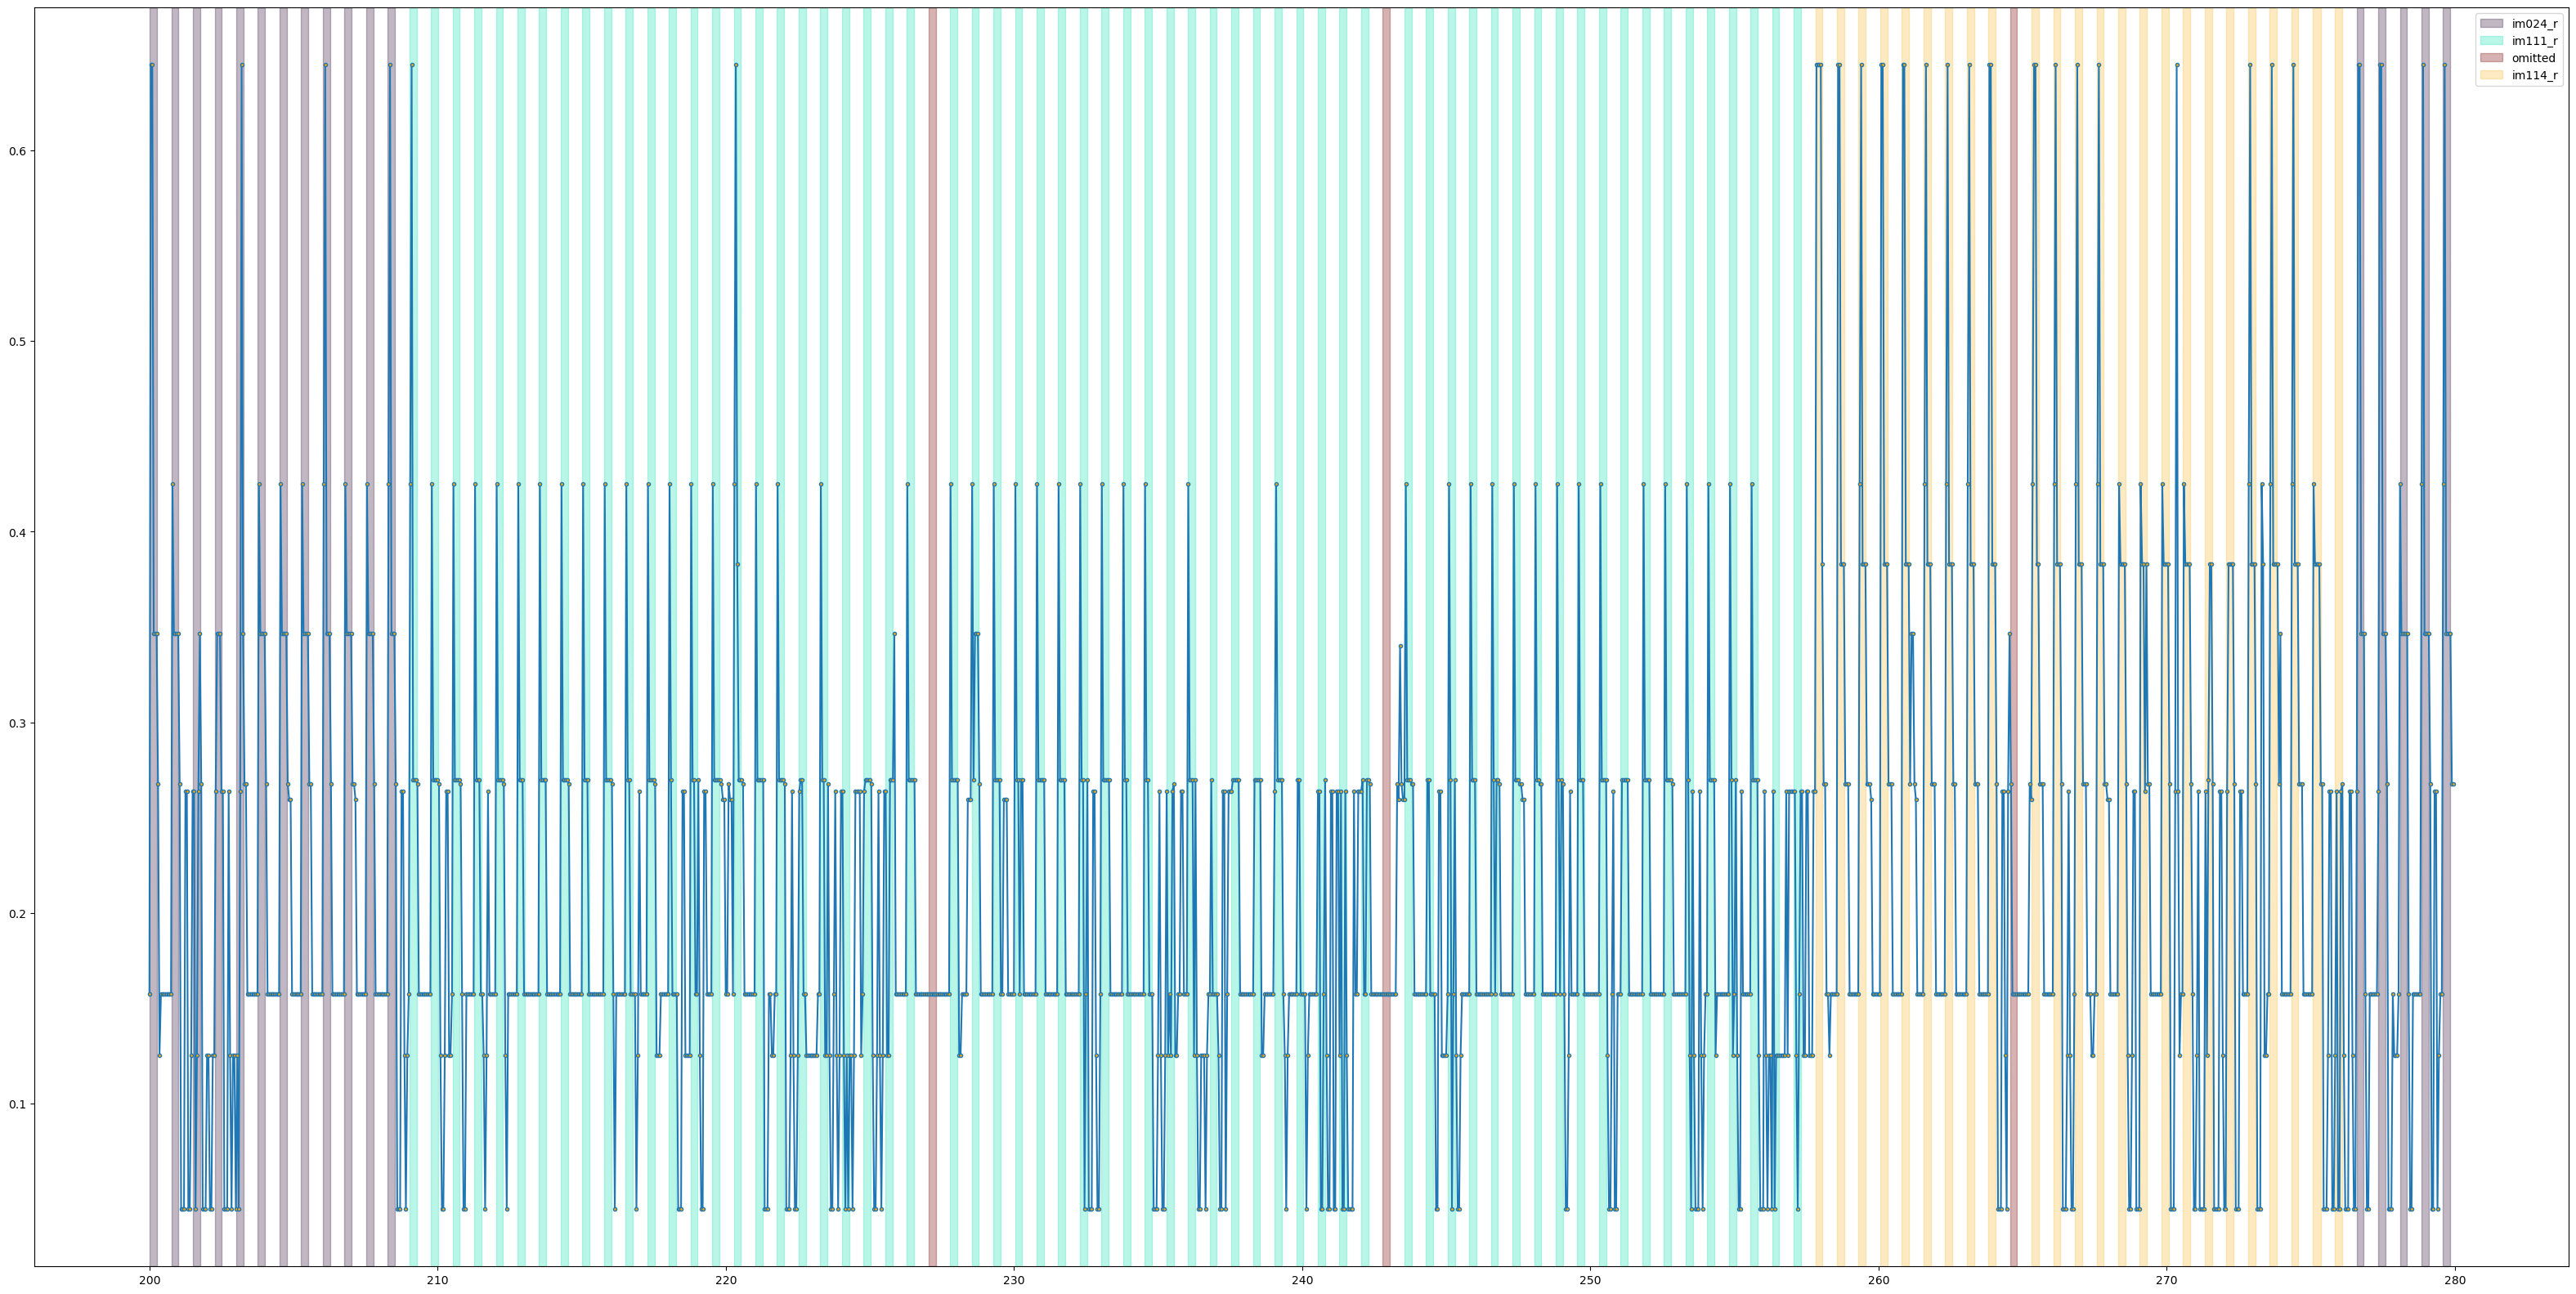

In [ ]:
lambdas = np.mean(model.lambdas_[preds], axis = 1)
bin_size = 50
visualize_prediction(start_time, end_time, 200, 280, bin_size, lambdas)

### K-fold CV with entropy

In [ ]:
n_fold = 6
bin_num = np.arange(4,21)
entropies = {'u':np.zeros(8), 'h':np.zeros(8), 'm':np.zeros(8), 'g':0}
total_entropy = {n: copy.deepcopy(entropies) for n in bin_num}
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
X = getX(start_time,end_time,bin_size).T
for n in tqdm(bin_num):
    print("n: ", n)
    frac_time = (end_time - start_time) / n_fold
    frac_state = int(len(X) / 10)
    u = np.zeros(8)
    h = np.zeros(8)
    m = np.zeros(8)
    g = 0
    for i in range(n_fold-1):
        X_train = X[0:(i+1)*frac_state]
        X_test = X[(i+1)*frac_state:(i+2)*frac_state]
        train_start = start_time
        train_end = start_time + (i+1) * frac_time
        test_start = train_end
        test_end = test_start + frac_time
        model = hmm.PoissonHMM(n_components=n, n_iter=1000, tol=100, verbose=False)
        model.fit(X_train)
        preds = model.predict(X_test)
        unchanged, hit, miss, gray = states_per_img_no_first(test_start, test_end, bin_size, preds)

        u += get_entropy(unchanged)
        h += get_entropy(hit)
        m += get_entropy(miss)
        g += get_entropy_gray(gray)

    u = u / n_fold
    h = h / n_fold
    m = m / n_fold
    g = g / n_fold
    total_entropy[n]['u'] = u
    print(u)
    total_entropy[n]['h'] = h
    print(h)
    total_entropy[n]['m'] = m
    print(m)
    total_entropy[n]['g'] = g
    print(g)
    print("----------------------")
        

In [ ]:
trials = list(total_entropy.keys())
u_total = np.zeros(len(trials))
h_total = np.zeros(len(trials))
m_total = np.zeros(len(trials))
g_total = np.zeros(len(trials))
for idx, trial in enumerate(trials):
    u_total[idx] = np.mean(total_entropy[trial]['u']) / np.log2(trial)
    h_total[idx] = np.mean(total_entropy[trial]['h']) / np.log2(trial) 
    m_total[idx] = np.mean(total_entropy[trial]['m']) / np.log2(trial)
    g_total[idx] = total_entropy[trial]['g'] / np.log2(trial)

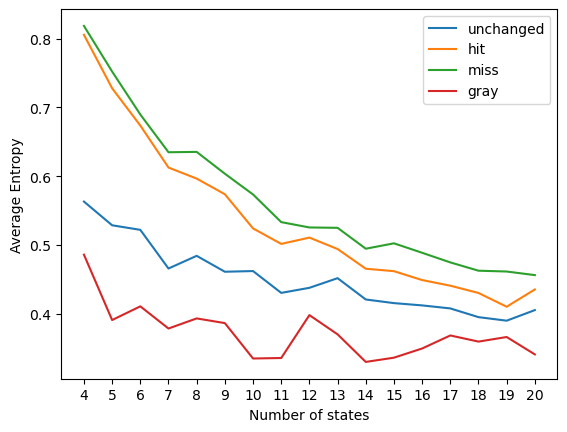

In [ ]:
plt.plot(u_total, label='unchanged')
plt.plot(h_total, label='hit')
plt.plot(m_total, label='miss')
plt.plot(g_total, label='gray')
plt.xticks(ticks=np.arange(0,17),labels=np.arange(4,21))
plt.xlabel("Number of states")
plt.ylabel("Average Entropy")
plt.legend();

### Comparing the influence of training tolerance

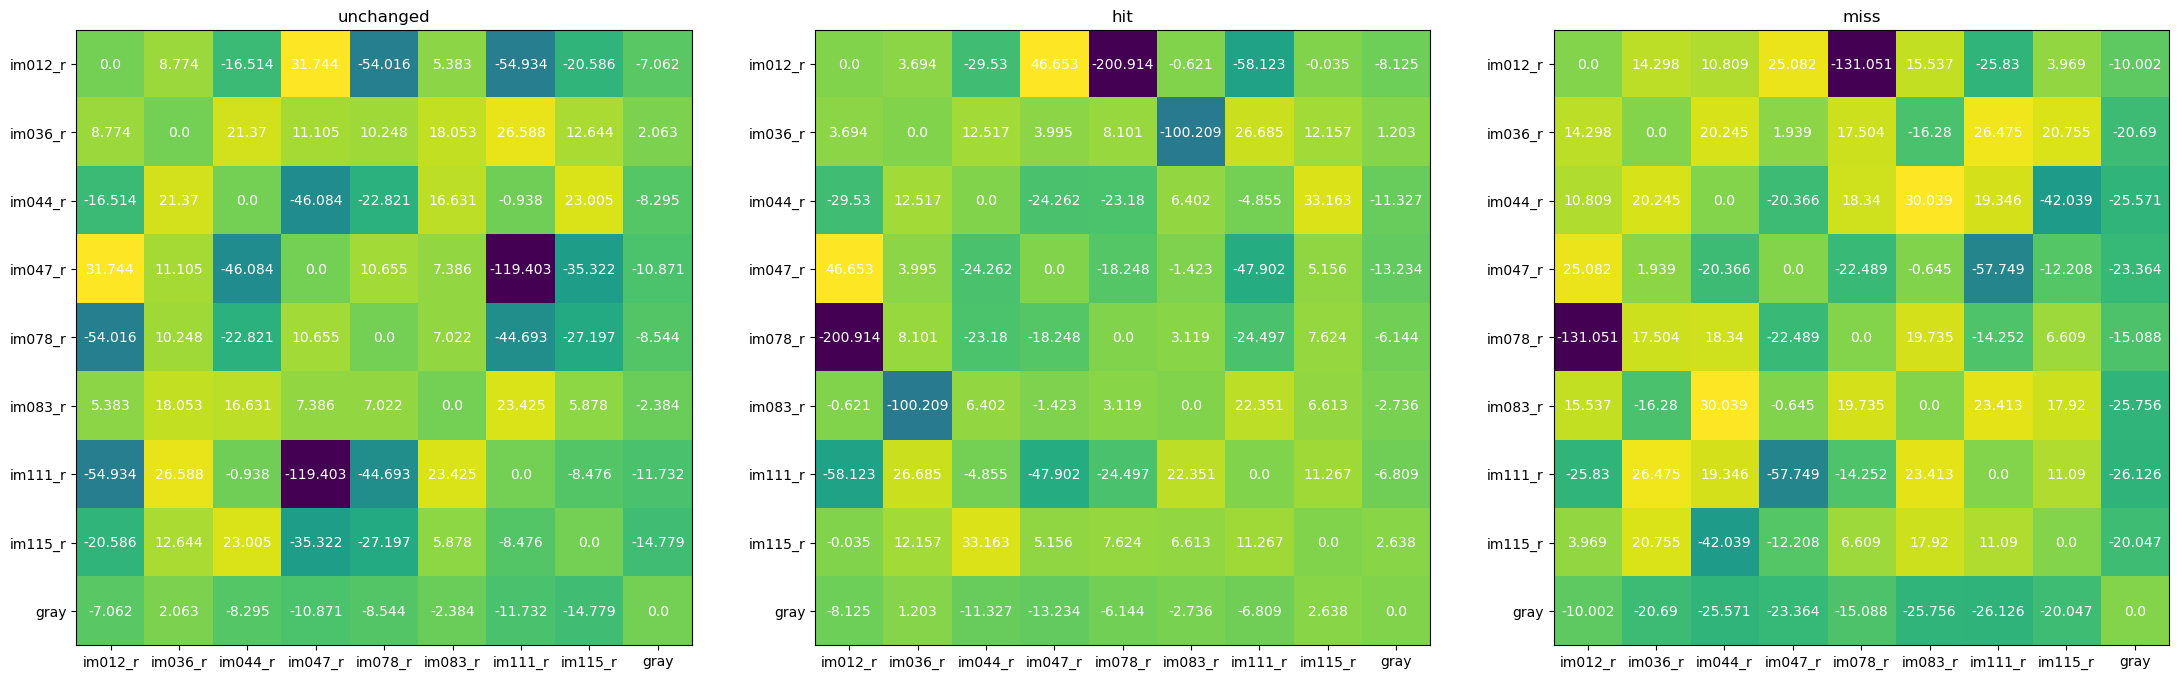

In [ ]:
diff_diff = (np.array(diff_1_avg) - np.array(diff_10_avg)) / (np.array(diff_1_avg)+1e-10) * 100
fig, axs = plt.subplots(1,3, figsize=(27,9))
titles = ['unchanged', 'hit', 'miss']
imgs = list(unchanged_01.keys())
imgs[-1] = 'gray'
for idx, ax in enumerate(axs):
    ax.imshow(diff_diff[idx])
    ax.set_title(titles[idx])
    ax.set_xticks(np.arange(0,9))
    ax.set_xticklabels(imgs)
    ax.set_yticks(np.arange(0,9))
    ax.set_yticklabels(imgs)
    for jdx in range(len(imgs)):
        for kdx in range(len(imgs)):
            ax.text(jdx, kdx, np.round(diff_diff[idx][jdx][kdx], decimals=3), ha="center", va="center", color="w")

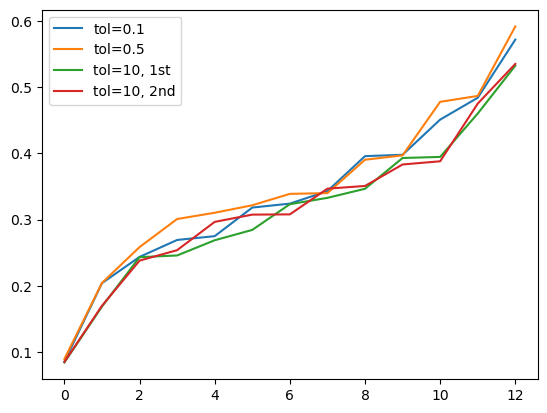

In [ ]:
plt.plot(np.sort(np.mean(model_01.lambdas_, axis=1)), label='tol=0.1')
plt.plot(np.sort(np.mean(model_05.lambdas_, axis=1)), label='tol=0.5')
plt.plot(np.sort(np.mean(model_10.lambdas_, axis=1)), label='tol=10, 1st')
plt.plot(np.sort(np.mean(model_10_2.lambdas_, axis=1)), label='tol=10, 2nd')
plt.legend();

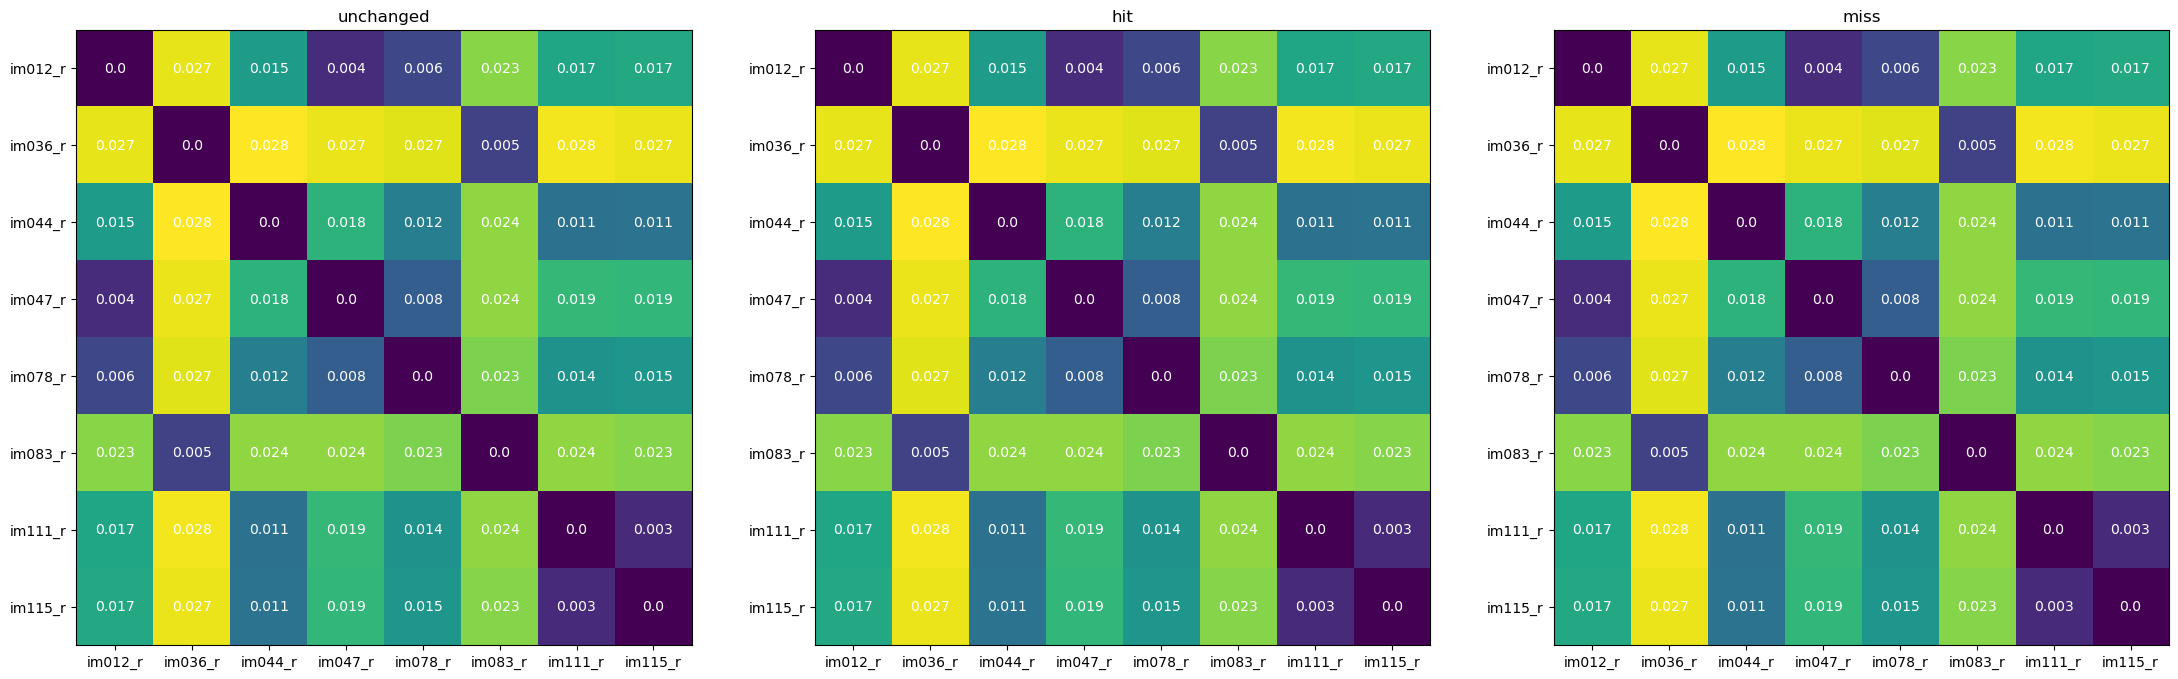

In [ ]:
similarity_normalize(unchanged, hit, miss)

### Compare Hidden State Distribution for each Image in different runs

c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Jerry\anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


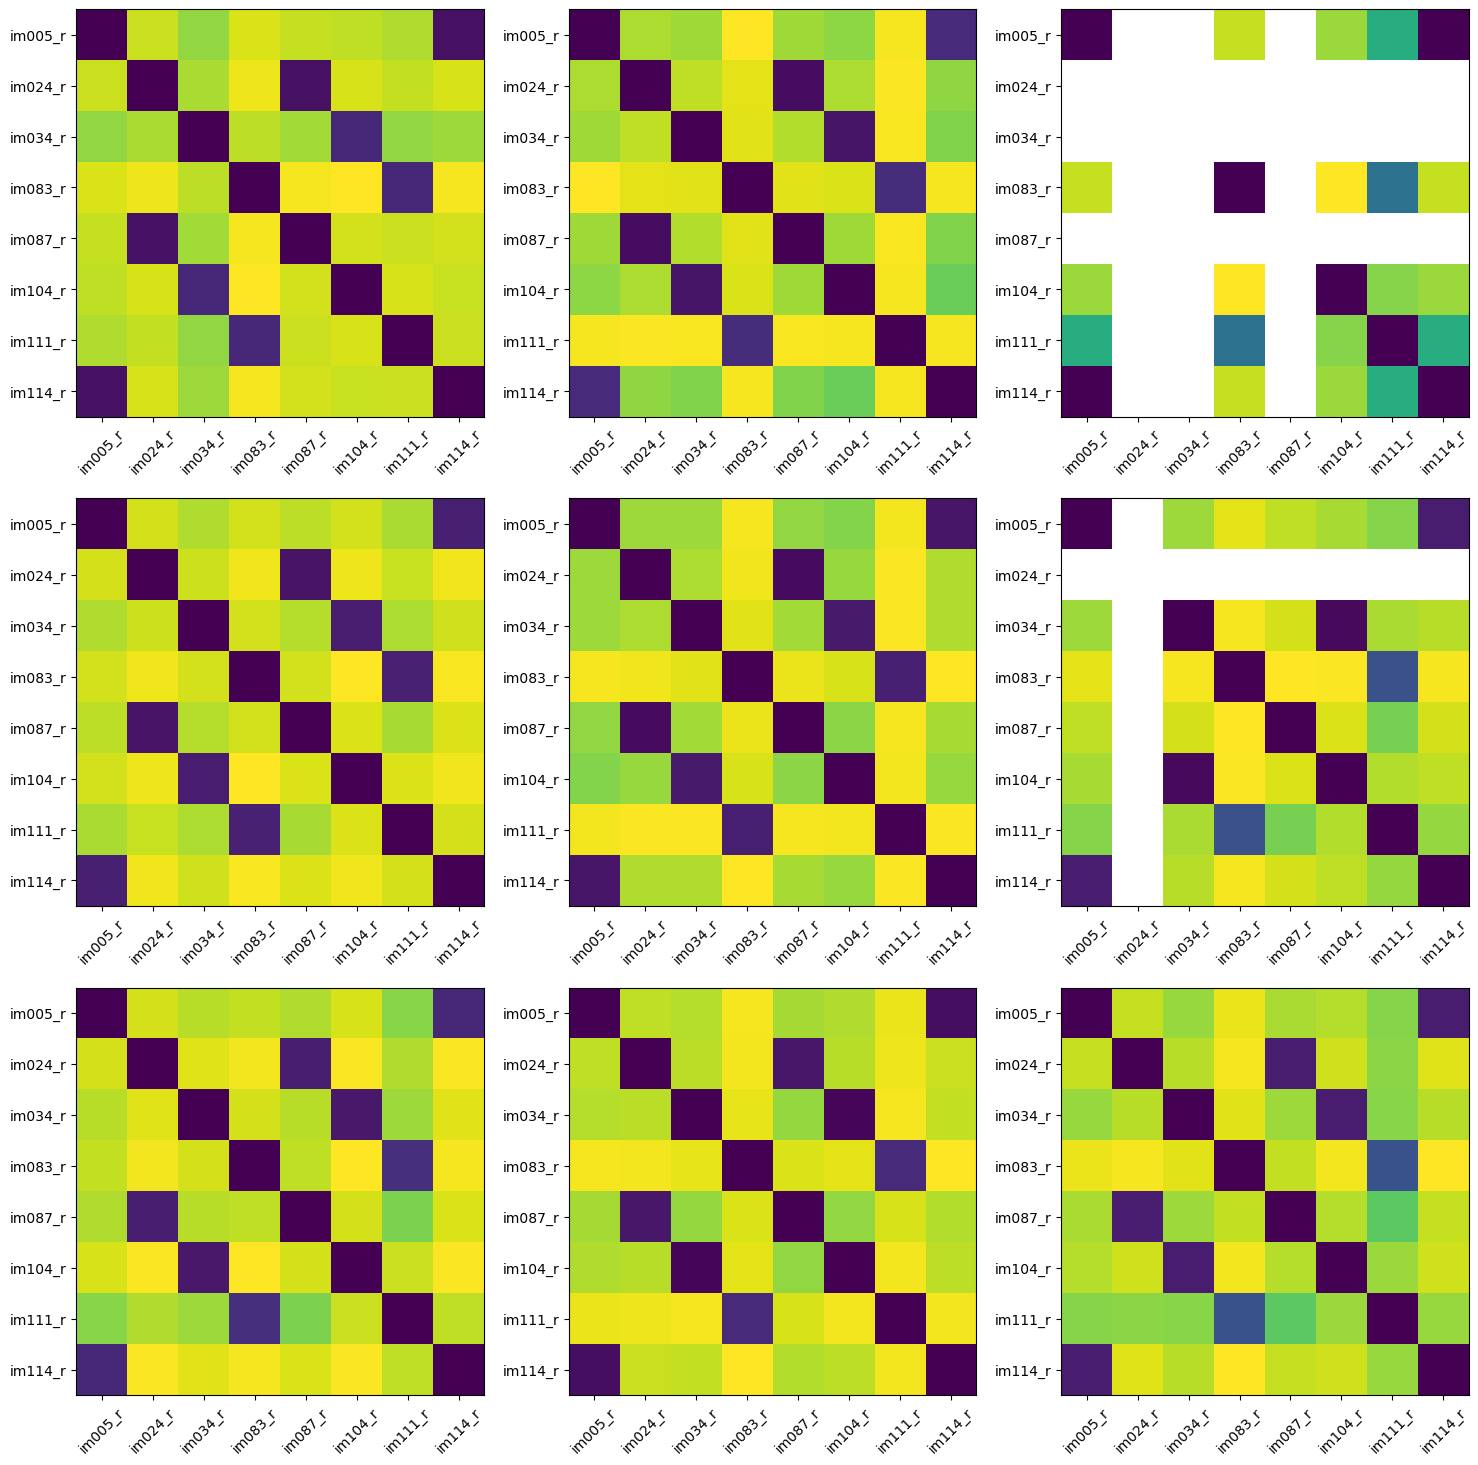

In [ ]:
n = 3
fig, ax = plt.subplots(n, 3 ,figsize=(18,18))
lower_bound = 0
upper_bound = 0
frac = int(1/n * len(preds))
for idx in range(n):
    lower_bound = 0 # Continue from the last upper bound
    lower_time = start_time + lower_bound * bin_size / 1000
    upper_bound = (idx + 1) * frac
    upper_time = start_time + upper_bound * bin_size / 1000
    preds_sub = preds[lower_bound:upper_bound]
    unchanged, hit, miss, gray = states_per_img_no_first(lower_time, upper_time, bin_size, preds_sub)
    imgs = list(unchanged.keys())[0:-1]
    u = np.zeros([len(imgs), len(imgs)])
    h = np.zeros([len(imgs), len(imgs)])
    m = np.zeros([len(imgs), len(imgs)])
    for kdx, img in enumerate(imgs):
        for jdx, img_2 in enumerate(imgs):
            u_1 = np.array(list(unchanged[img].values()))
            u_1 = u_1 / np.sum(u_1)
            u_2 = np.array(list(unchanged[img_2].values()))
            u_2 = u_2 / np.sum(u_2)
            h_1 = np.array(list(hit[img].values()))
            h_1 = h_1 / np.sum(h_1)
            h_2 = np.array(list(hit[img_2].values()))
            h_2 = h_2 / np.sum(h_2)
            m_1 = np.array(list(miss[img].values()))
            m_1 = m_1 / np.sum(m_1)
            m_2 = np.array(list(miss[img_2].values()))
            m_2 = m_2 / np.sum(m_2)
            u[kdx][jdx] = np.linalg.norm(u_1-u_2)
            h[kdx][jdx] = np.linalg.norm(h_1-h_2)
            m[kdx][jdx] = np.linalg.norm(m_1-m_2)
    #plt.figure(figsize=(10,7))
    ax[idx][0].imshow(u)
    ax[idx][1].imshow(h)
    ax[idx][2].imshow(m)
    ax[idx][0].set_xticks(np.arange(len(imgs)))
    ax[idx][0].set_xticklabels(imgs, rotation=45)
    ax[idx][0].set_yticks(np.arange(len(imgs)))
    ax[idx][0].set_yticklabels(imgs)
    ax[idx][1].set_xticks(np.arange(len(imgs)))
    ax[idx][1].set_xticklabels(imgs, rotation=45)
    ax[idx][1].set_yticks(np.arange(len(imgs)))
    ax[idx][1].set_yticklabels(imgs)
    ax[idx][2].set_xticks(np.arange(len(imgs)))
    ax[idx][2].set_xticklabels(imgs, rotation=45)
    ax[idx][2].set_yticks(np.arange(len(imgs)))
    ax[idx][2].set_yticklabels(imgs)

### MSE and SSIM Image Comparisons

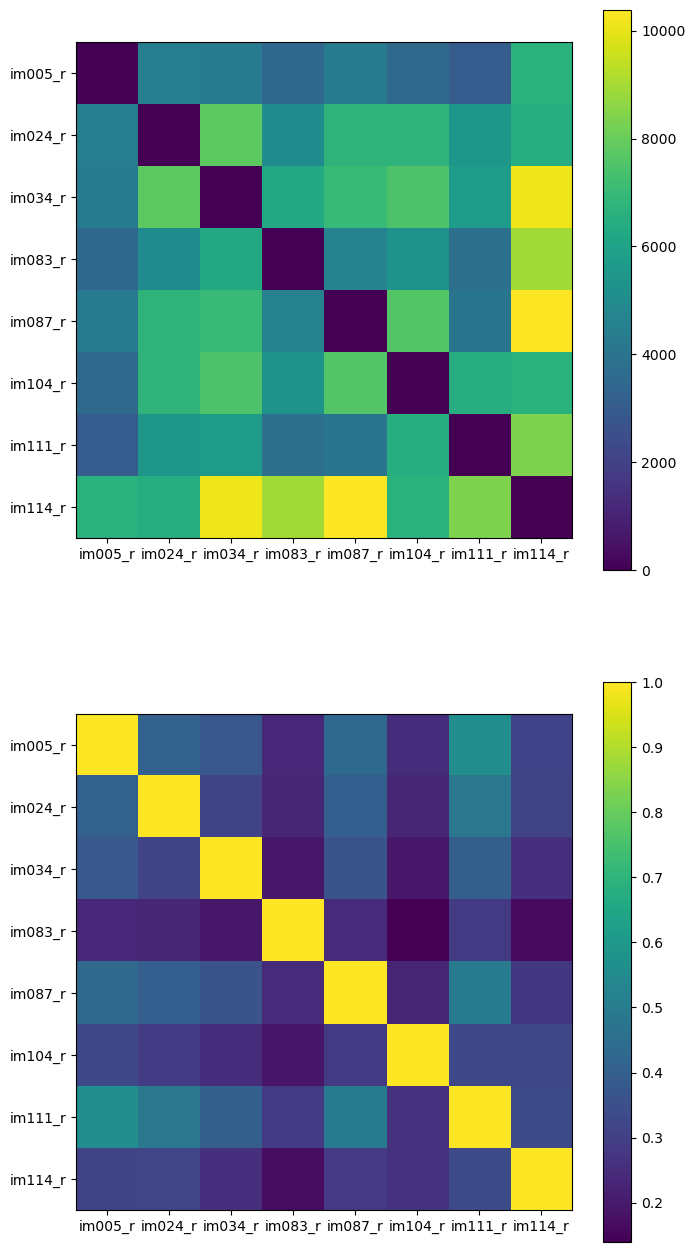

In [ ]:
fig, ax = plt.subplots(2,figsize=(8,16))
imgs = list(behavior.stimulus_templates.warped.keys())
imgs.sort()

mse_scores = np.zeros((len(imgs),len(imgs)))
ssim_scores = np.zeros((len(imgs),len(imgs)))
for idx, img in enumerate(imgs):
    for jdx, img2 in enumerate(imgs):
        img_1 = behavior.stimulus_templates.warped[img]
        img_2 = behavior.stimulus_templates.warped[img2]
        mse_scores[idx][jdx] = mean_squared_error(img_1, img_2)
        ssim_scores[idx][jdx] = ssim(img_1, img_2, data_range=img_2.max() - img_2.min())

img1 = ax[0].imshow(mse_scores);
ax[0].set_xticks(ticks=np.arange(0,8));
ax[0].set_xticklabels(imgs)
ax[0].set_yticks(ticks=np.arange(0,8));
ax[0].set_yticklabels(imgs)
fig.colorbar(img1, ax=ax[0]);
img2 = ax[1].imshow(ssim_scores)
ax[1].set_xticks(ticks=np.arange(0,8));
ax[1].set_xticklabels(imgs)
ax[1].set_yticks(ticks=np.arange(0,8));
ax[1].set_yticklabels(imgs)
fig.colorbar(img2, ax=ax[1]);

### Preparing data for rastermap

In [ ]:
start_time = 0
end_time = 3000
bin_size = 50
#spks
X_train = getX(start_time,end_time,bin_size)
#run
running_speed = session.running_speed
timestamp_end = np.where(running_speed['timestamps'] > end_time)[0][0]
timestamps = running_speed['timestamps'][:timestamp_end]
speed = running_speed['speed'][0:timestamp_end]
interp = np.arange(25.50, end_time, bin_size/1000)
padding = np.zeros(len(np.arange(0,25.50,bin_size/1000)))
run = np.interp(interp, timestamps, speed)
run = np.concatenate((padding, run))
#lick
licks = np.array(session.licks['timestamps'])
stop_idx = np.where(licks > end_time)[0][0]
licks = licks[:stop_idx]
licks = licks / (bin_size / 1000)
#store
data = {'run':run, 'spks': X_train, 'licks':licks}
path = "E:/jerry/vbn_s3_cache/visual-behavior-neuropixels-0.5.0/behavior_ecephys_sessions/1064644573/1064644573_0_3000_50_all.npy"
np.save(path, data, allow_pickle=True)

100%|████████████████████████████████████████████████████████████████████████████████| 271/271 [00:07<00:00, 35.59it/s]


### Plotting Entropy for each session v.s. number of hidden states

In [ ]:
def plot_average_values(total_entropy,name):
    if (total_entropy == -1):
        print("Session not complete")
        return
    trials = list(total_entropy.keys())
    fig, axs = plt.subplots(1,4, figsize=(20,5))
    fig.suptitle(name)
    u_total = np.zeros(8)
    h_total = np.zeros(8)
    m_total = np.zeros(8)
    g_total = np.zeros(len(trials))
    for idx, trial in enumerate(trials):
        u_total = np.vstack((u_total, np.array(list(total_entropy.values()))[idx]['u'] / np.log2(trial)))
        h_total = np.vstack((h_total, np.array(list(total_entropy.values()))[idx]['h']/ np.log2(trial)))
        m_total = np.vstack((m_total, np.array(list(total_entropy.values()))[idx]['m']/ np.log2(trial)))
        g_total[idx] = total_entropy[trial]['g'] / np.log2(trial)
    u_total = np.delete(u_total, 0,0)
    h_total = np.delete(h_total, 0,0)
    m_total = np.delete(m_total, 0,0)
    totals = [u_total, h_total, m_total, g_total]
    titles = ['unchanged', 'hit', 'miss', 'average']
    for idx in range(3):
        axs[idx].plot(totals[idx])
        axs[idx].set_xticks(ticks=np.arange(0,10))
        axs[idx].set_xticklabels(np.arange(8,18))
        axs[idx].set_title(titles[idx])
    axs[3].plot(np.mean(u_total, axis=1), label='unchanged')
    #axs[3].plot(np.mean(h_total, axis=1), label='hit')
    #axs[3].plot(np.mean(m_total, axis=1), label='miss')
    axs[3].plot(g_total, label='gray')
    axs[3].set_title("Average")
    axs[3].set_xticks(np.arange(0,10))
    axs[3].set_xticklabels(np.arange(8,18))
    axs[3].legend()
    path = "C:/Users/jerry/Downloads/HMM_entropy_2/" + str(name) + ".png"
    plt.savefig(path)

def read_txt_file(path):
    try:
        with open(path, 'r') as file:
            content = file.read()
        content = content.replace('       ', ' ')
        content = content.replace('\n', '')
        content = re.sub(r'array\((.*?)\)', r'\1', content)
        dictionary = eval(content)
        return dictionary
    except FileNotFoundError:
        #print("File not found.")
        return -1
    except SyntaxError:
        print("Invalid syntax. The content does not follow the syntax of a dictionary.")
        return -1

def get_entropy(name):
    path = "C:/Users/jerry/Downloads/HMM_CV/" + str(name) + ".txt"
    dictionary = read_txt_file(path)
    plot_average_values(dictionary, name)

In [ ]:
ecephys_table = cache.get_ecephys_session_table()
session_ids = list(ecephys_table.index)
for id in session_ids:
    get_entropy(id)

### Comparing entropy for different tol for each session

In [ ]:
def plot_average_values(total_entropy, name):
    if (total_entropy == -1):
        print("Session not complete")
        return
    trials = list(total_entropy.keys())
    fig, axs = plt.subplots(1,4, figsize=(20,5))
    fig.suptitle(name)
    u_total = np.zeros(8)
    h_total = np.zeros(8)
    m_total = np.zeros(8)
    g_total = np.zeros(len(trials))
    for idx, trial in enumerate(trials):
        u_total = np.vstack((u_total, np.array(list(total_entropy.values()))[idx]['u'] / np.log2(trial)))
        h_total = np.vstack((h_total, np.array(list(total_entropy.values()))[idx]['h']/ np.log2(trial)))
        m_total = np.vstack((m_total, np.array(list(total_entropy.values()))[idx]['m']/ np.log2(trial)))
        g_total[idx] = total_entropy[trial]['g'] / np.log2(trial)
    u_total = np.delete(u_total, 0,0)
    h_total = np.delete(h_total, 0,0)
    m_total = np.delete(m_total, 0,0)
    totals = [u_total, h_total, m_total, g_total]
    titles = ['unchanged', 'hit', 'miss', 'average']
    for idx in range(3):
        axs[idx].plot(totals[idx])
        axs[idx].set_xticks(ticks=np.arange(0,17))
        axs[idx].set_xticklabels(np.arange(4,21))
        axs[idx].set_title(titles[idx])
    axs[3].plot(np.mean(u_total, axis=1), label='unchanged')
    #axs[3].plot(np.mean(h_total, axis=1), label='hit')
    #axs[3].plot(np.mean(m_total, axis=1), label='miss')
    axs[3].plot(g_total, label='gray')
    axs[3].set_title("Average")
    axs[3].set_xticks(np.arange(0,17))
    axs[3].set_xticklabels(np.arange(4,21))
    axs[3].legend()
    #path = "C:/Users/jerry/Downloads/HMM_entropy/" + str(name) + ".png"
    #plt.savefig(path)

#### Session number: 1044385384
Day 1

In [ ]:
path_1_1 = "C:/Users/jerry/Downloads/1.txt"
path_1_10 = "C:/Users/jerry/Downloads/1044385384/10.txt"
path_1_100 = "C:/Users/jerry/Downloads/1044385384/100.txt"

day_1_1 = read_txt_file(path_1_1)
day_1_10 = read_txt_file(path_1_10)
day_1_100 = read_txt_file(path_1_100)

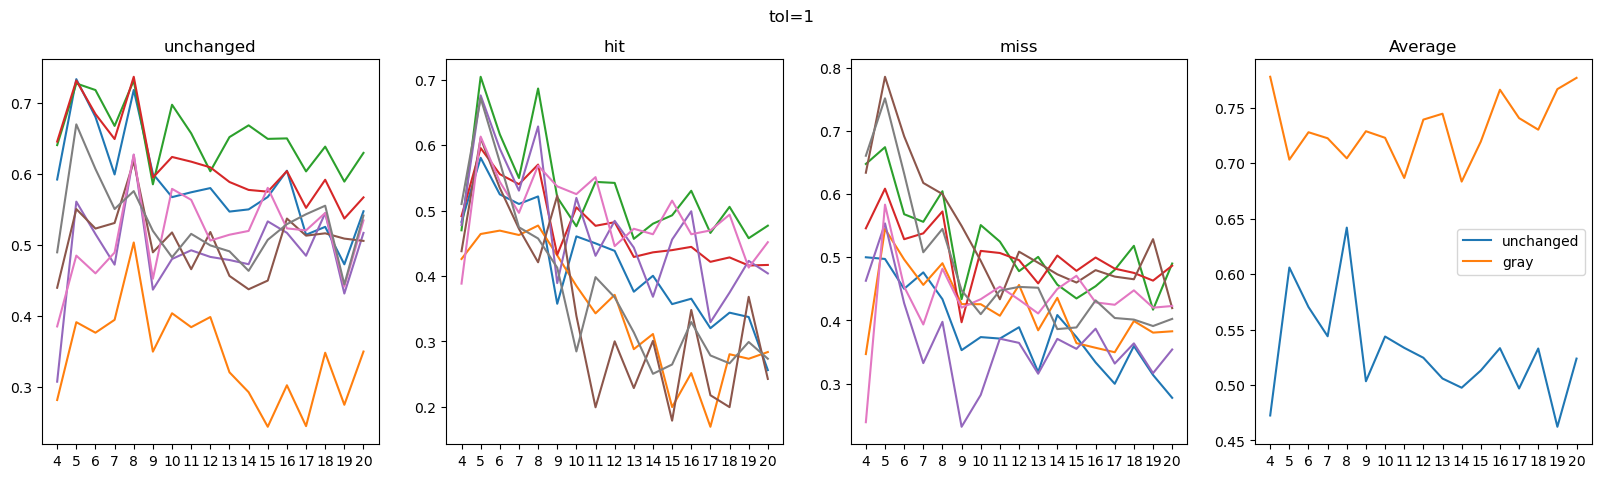

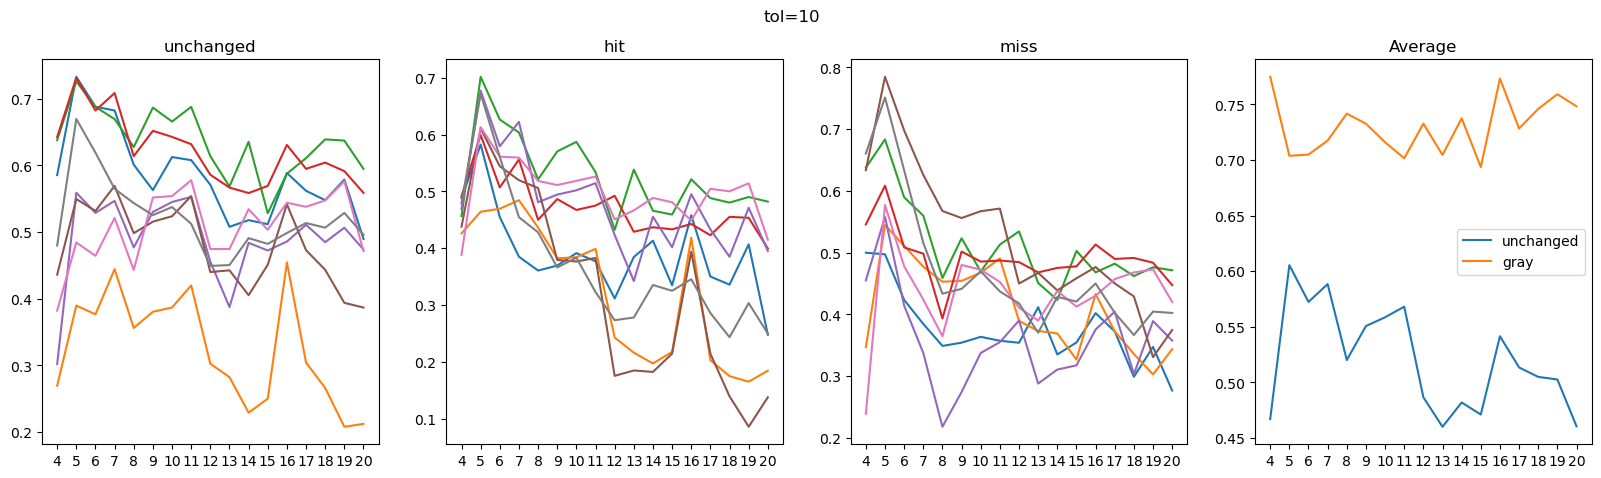

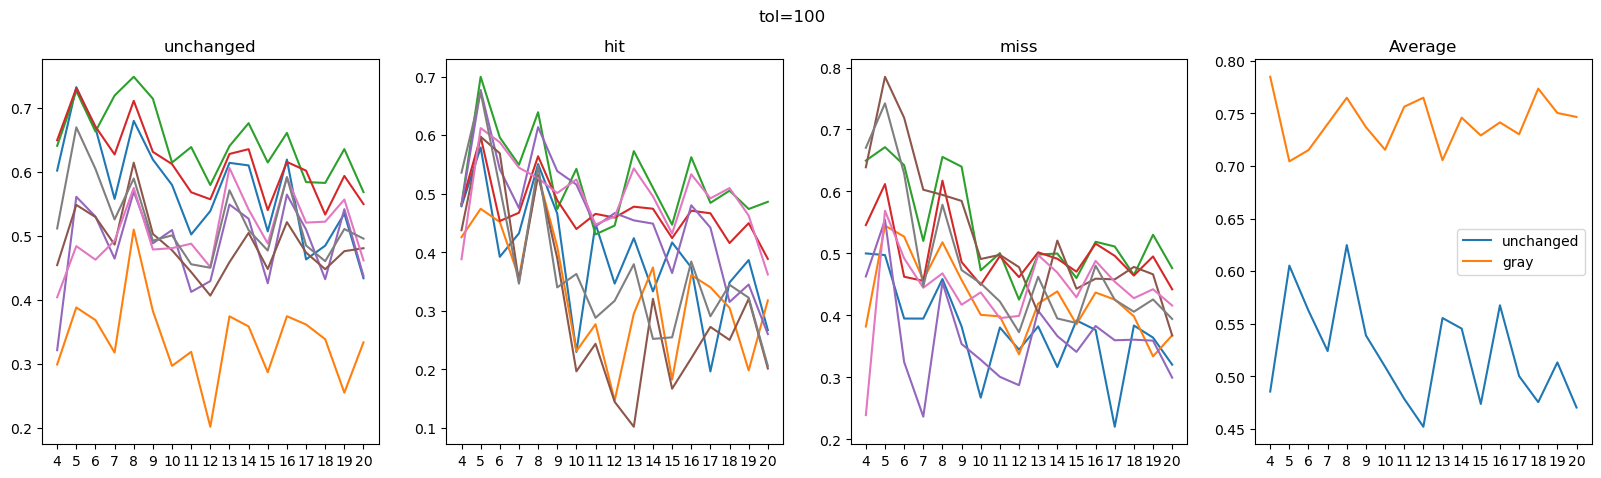

In [ ]:
plot_average_values(day_1_1, "tol=1")
plot_average_values(day_1_10, "tol=10")
plot_average_values(day_1_100, "tol=100")

#### Session number: 1044594870
Day 2

In [ ]:
path_2_10 = "C:/Users/jerry/Downloads/1044594870/10.txt"
path_2_100 = "C:/Users/jerry/Downloads/1044594870/100.txt"
day_2_10 = read_txt_file(path_2_10)
day_2_100 = read_txt_file(path_2_100)

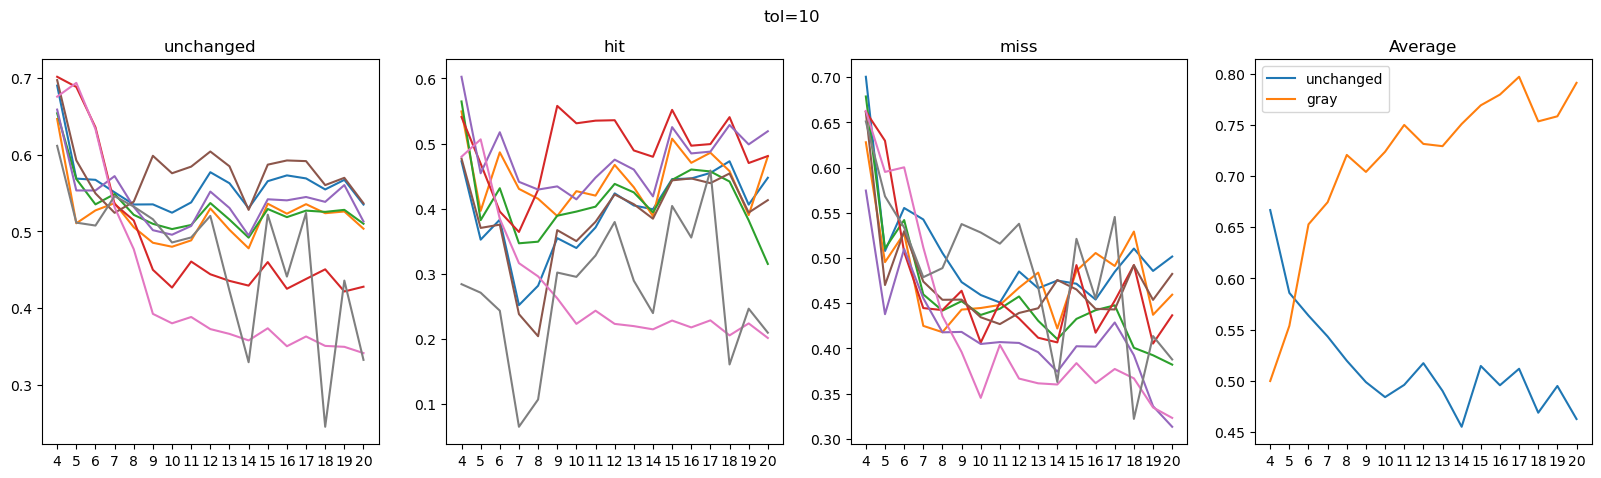

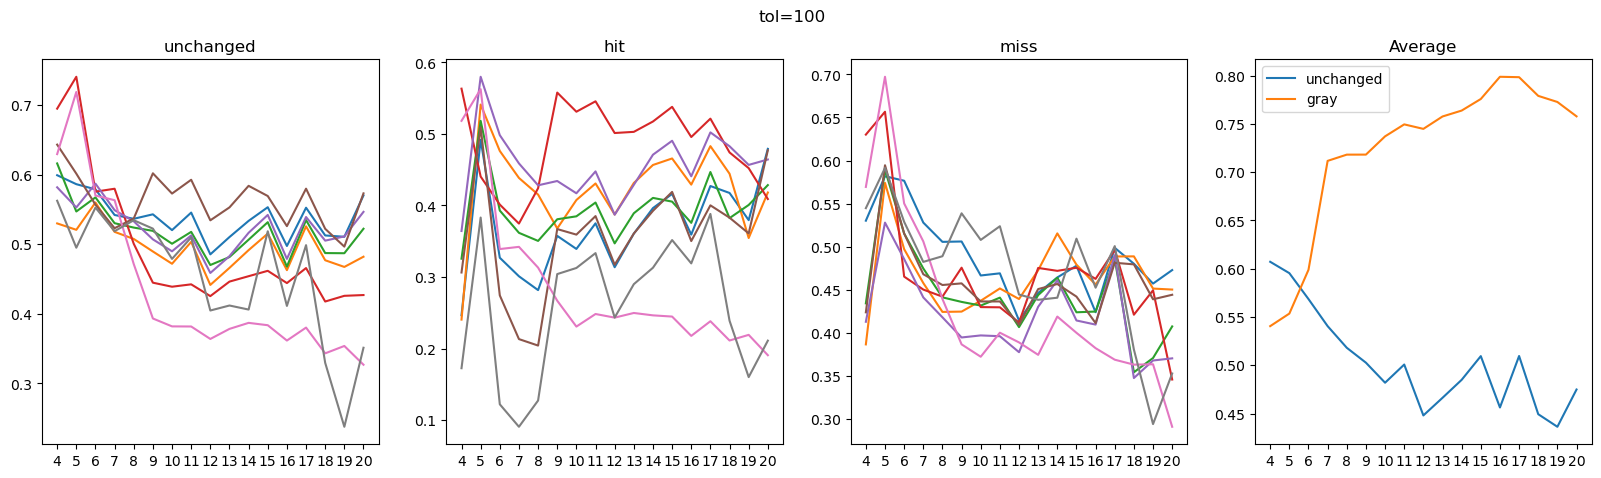

In [ ]:
plot_average_values(day_2_10, "tol=10")
plot_average_values(day_2_100, "tol=100")

#### Plot changes instead of average values

In [ ]:
def plot_average_change(total_entropy, name):
    plt.ion()
    trials = list(total_entropy.keys())
    fig, axs = plt.subplots(1,4, figsize=(20,5))
    fig.suptitle(name)
    u_total = np.zeros(8)
    h_total = np.zeros(8)
    m_total = np.zeros(8)
    g_total = np.zeros(len(trials))
    for idx, trial in enumerate(trials):
        u_raw = np.array(list(total_entropy.values()))[idx]['u'] / np.log2(trial)
        u_change = np.concatenate(([0], [(u_raw[i+1] - u_raw[i]) / u_raw[i] for i in range(len(u_raw)-1)]))
        u_total = np.vstack((u_total, u_change))
        h_raw = np.array(list(total_entropy.values()))[idx]['h']/ np.log2(trial)
        h_change = np.concatenate(([0], [(h_raw[i+1] - h_raw[i]) / h_raw[i] for i in range(len(h_raw)-1)]))
        h_total = np.vstack((h_total, h_change))
        m_raw = np.array(list(total_entropy.values()))[idx]['m']/ np.log2(trial)
        m_change = np.concatenate(([0], [(m_raw[i+1] - m_raw[i]) / m_raw[i] for i in range(len(m_raw)-1)]))
        m_total = np.vstack((m_total, m_change))
        g_total[idx] = total_entropy[trial]['g'] / np.log2(trial)
    u_total = np.delete(u_total, 0,0)
    h_total = np.delete(h_total, 0,0)
    m_total = np.delete(m_total, 0,0)
    g_total = np.concatenate(([0], [(g_total[i+1] - g_total[i]) / g_total[i] for i in range(len(g_total)-1)]))
    totals = [u_total, h_total, m_total, g_total]
    titles = ['unchanged', 'hit', 'miss', 'average']
    for idx in range(3):

        axs[idx].plot(totals[idx])
        axs[idx].set_xticks(ticks=np.arange(0,10))
        axs[idx].set_xticklabels(np.arange(8,18))
        axs[idx].set_title(titles[idx])
    axs[3].plot(np.mean(u_total, axis=1), label='unchanged')
    #axs[3].plot(np.mean(h_total, axis=1), label='hit')
    #axs[3].plot(np.mean(m_total, axis=1), label='miss')
    axs[3].plot(g_total, label='gray')
    axs[3].set_title("Average")
    axs[3].set_xticks(np.arange(0,10))
    axs[3].set_xticklabels(np.arange(8,18))
    axs[3].legend()
    plt.show()
    #path = "C:/Users/jerry/Downloads/HMM_entropy/" + str(name) + ".png"
    #plt.savefig(path)"""

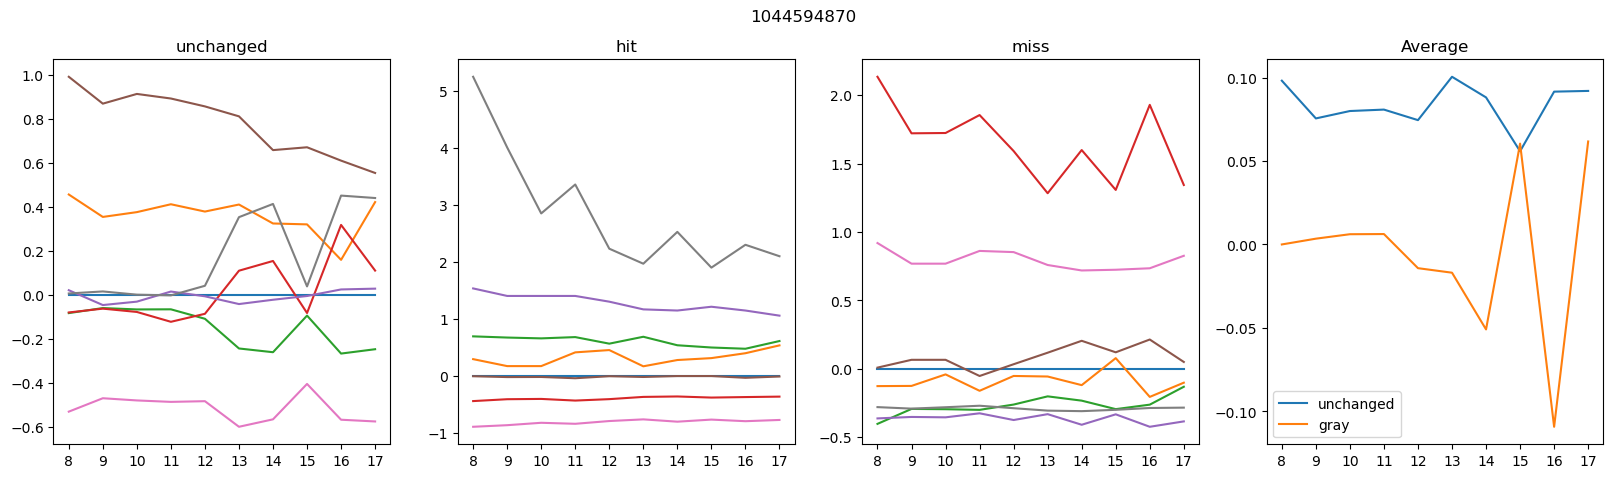

In [ ]:
path = "C:/Users/jerry/Downloads/HMM_CV/1044594870.txt"
dictionary = read_txt_file(path)
plot_average_change(dictionary, "1044594870")

In [ ]:
table = cache.get_ecephys_session_table()
table = table.reset_index()
grouped = table.groupby(["image_set", "session_number"]).agg(list)

g1_mouse = grouped.loc[('G',1)]['mouse_id']
g2_mouse = grouped.loc[('G',2)]['mouse_id']
h1_mouse = grouped.loc[('H',1)]['mouse_id']
h2_mouse = grouped.loc[('H',2)]['mouse_id']

g1h2_mouse = list(set(g1_mouse).intersection(set(h2_mouse)))
g2h1_mouse = list(set(g2_mouse).intersection(set(h1_mouse)))
g1g2_mouse = list(set(g1_mouse).intersection(set(g2_mouse)))
h1h2_mouse = list(set(h1_mouse).intersection(set(h2_mouse)))

In [ ]:
grouped_mouse = table.groupby(["mouse_id", "image_set", "session_number"]).agg(list)

g1h2_g1 = flatten(grouped_mouse.loc[(g1h2_mouse, 'G', 1)]['ecephys_session_id'].values)
g1h2_h2 = flatten(grouped_mouse.loc[(g1h2_mouse, 'H', 2)]['ecephys_session_id'].values)
g2h1_g2 = flatten(grouped_mouse.loc[(g2h1_mouse, 'G', 2)]['ecephys_session_id'].values)
g2h1_h1 = flatten(grouped_mouse.loc[(g2h1_mouse, 'H', 1)]['ecephys_session_id'].values)
g1g2_g1 = flatten(grouped_mouse.loc[(g1g2_mouse, 'G', 1)]['ecephys_session_id'].values)
g1g2_g2 = flatten(grouped_mouse.loc[(g1g2_mouse, 'G', 2)]['ecephys_session_id'].values)
h1h2_h1 = flatten(grouped_mouse.loc[(h1h2_mouse, 'H', 1)]['ecephys_session_id'].values)
h1h2_h2 = flatten(grouped_mouse.loc[(h1h2_mouse, 'H', 2)]['ecephys_session_id'].values)


### Training each session and visualize using UMAP

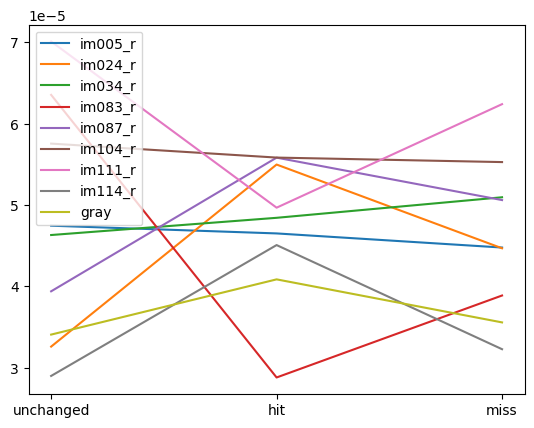

In [ ]:
for i in range(9):
    plt.plot(np.arange(3),np.var(averaged_diff[:, i:i+1, :],axis=2), label=imgs[i])
plt.xticks(ticks=np.arange(0,3),labels=['unchanged', 'hit', 'miss'])
plt.legend();

In [ ]:
color = ['pink', 'blue', 'cyan','green', 'yellow', 'orange', 'red', 'brown', 'black', 'gray']

#### Whole VIS

##### Day 1: G

##### Day 2: H

#### Things to try

In [ ]:
def similarity_redo(unchanged, hit, miss, gray, imgs):
    diff_u = np.zeros([len(imgs), len(imgs)])
    diff_h = np.zeros([len(imgs)-2, len(imgs)-2])
    diff_m = np.zeros([len(imgs)-2, len(imgs)-2])
    unchanged = np.vstack((unchanged, gray))
    for idx, img_1 in enumerate(imgs):
        u_1 = normalize(unchanged[idx])
        for jdx, img_2 in enumerate(imgs):
            u_2 = normalize(unchanged[jdx])
            diff_u[idx][jdx] = np.linalg.norm(u_1-u_2)

    for idx in range(len(imgs)-2):
        h_1 = normalize(hit[idx])
        m_1 = normalize(miss[idx])
        for jdx in range(len(imgs)-2):
            h_2 = normalize(hit[jdx])
            m_2 = normalize(miss[jdx])
            diff_h[idx][jdx] = np.linalg.norm(h_1-h_2)
            diff_m[idx][jdx] = np.linalg.norm(m_1-m_2)
    diff_u = diff_u / np.sum(diff_u)
    diff_h = diff_h / np.sum(diff_h)
    diff_m = diff_m / np.sum(diff_m)
    return diff_u, diff_h, diff_m

In [ ]:
n_iters = 5
session_ids = np.sort(g1h2_h2)
u = np.zeros(10)
h = np.zeros(8)
m = np.zeros(8)
for idx, session_id in enumerate(session_ids):
    for jdx in range(n_iters):
        path = "C:/Users/jerry/Downloads/train2_2/" + str(session_id) + "_" + str(jdx) + ".npz"
        a = np.load(path, allow_pickle=True)
        u_a = a['u']
        h_a = a['h']
        m_a = a['m']
        g_a = a['g']
        h_a = np.delete(h_a, -1, 0)
        m_a = np.delete(m_a, -1, 0)
        diff_u, diff_h, diff_m = similarity_redo(u_a, h_a, m_a, g_a, imgs)
        u = np.vstack((u, diff_u))
        h = np.vstack((h, diff_h))
        m = np.vstack((m, diff_m))
u = np.delete(u, 0, 0)
h = np.delete(h, 0, 0)
m = np.delete(m, 0, 0)

umap_temp = umap.UMAP(n_neighbors=300, min_dist=1, spread=1, n_components=3, n_jobs=1, random_state=0)
u_transformed = umap_temp.fit_transform(u)
h_transformed = umap_temp.fit_transform(h)
m_transformed = umap_temp.fit_transform(m)

fig, ax = plt.subplots(1,3, figsize=(18,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax2 = fig.add_subplot(gs[0,1], projection='3d')
ax3 = fig.add_subplot(gs[0,2], projection='3d')

n_stimulus = 10

for i in range(len(session_ids)):
        for j in range(n_iters):
            for k in range(n_stimulus):
                index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
                ax1.scatter(u_transformed[index, 0], u_transformed[index, 1],u_transformed[index, 2], c=color[k])
    
n_stimulus -= 2

for i in range(len(session_ids)):
    for j in range(n_iters):
        for k in range(n_stimulus):
            index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
            ax2.scatter(h_transformed[index, 0], h_transformed[index, 1],h_transformed[index, 2], c=color[k])
            ax3.scatter(m_transformed[index, 0], m_transformed[index, 1],m_transformed[index, 2], c=color[k])
ax1.set_title("Unchanged");
ax2.set_title("Hit");
ax3.set_title("Miss");

#### 2D version of this

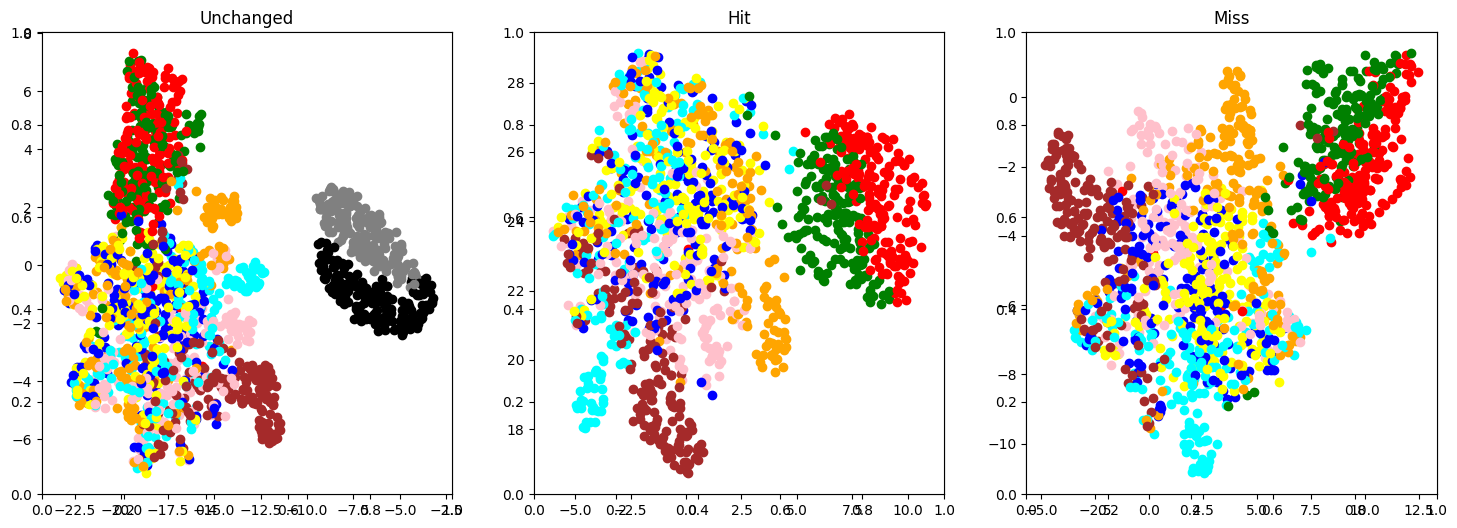

In [ ]:
n_iters = 5
session_ids = np.sort(g1h2_h2)
u = np.zeros(10)
h = np.zeros(8)
m = np.zeros(8)
for idx, session_id in enumerate(session_ids):
    for jdx in range(n_iters):
        path = "C:/Users/jerry/Downloads/train2_2/" + str(session_id) + "_" + str(jdx) + ".npz"
        a = np.load(path, allow_pickle=True)
        u_a = a['u']
        h_a = a['h']
        m_a = a['m']
        g_a = a['g']
        h_a = np.delete(h_a, -1, 0)
        m_a = np.delete(m_a, -1, 0)
        diff_u, diff_h, diff_m = similarity_redo(u_a, h_a, m_a, g_a, imgs)
        u = np.vstack((u, diff_u))
        h = np.vstack((h, diff_h))
        m = np.vstack((m, diff_m))
u = np.delete(u, 0, 0)
h = np.delete(h, 0, 0)
m = np.delete(m, 0, 0)

umap_temp = umap.UMAP(n_neighbors=300, min_dist=1, spread=1, n_components=2, n_jobs=1, random_state=0)
u_transformed = umap_temp.fit_transform(u)
h_transformed = umap_temp.fit_transform(h)
m_transformed = umap_temp.fit_transform(m)

fig, ax = plt.subplots(1,3, figsize=(18,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])

n_stimulus = 10

for i in range(len(session_ids)):
        for j in range(n_iters):
            for k in range(n_stimulus):
                index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
                ax1.scatter(u_transformed[index, 0], u_transformed[index, 1], c=color[k])
    
n_stimulus -= 2

for i in range(len(session_ids)):
    for j in range(n_iters):
        for k in range(n_stimulus):
            index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
            ax2.scatter(h_transformed[index, 0], h_transformed[index, 1], c=color[k])
            ax3.scatter(m_transformed[index, 0], m_transformed[index, 1], c=color[k])
ax1.set_title("Unchanged");
ax2.set_title("Hit");
ax3.set_title("Miss");

In [ ]:
path = "C:/Users/jerry/Downloads/train2_2/" + str(session_id) + "_" + str(0) + ".npz"
a = np.load(path, allow_pickle=True)
u_a = a['u']
h_a = a['h']
m_a = a['m']
g_a = a['g']

total = u_a + h_a + m_a
print(total/np.sum(total, axis=1,keepdims=True))
g_n = g_a / np.sum(g_a)
total = np.vstack((total, g_n))
diff = np.zeros([len(imgs), len(imgs)])
for idx, img_1 in enumerate(imgs):
    u_1 = total[idx]
    for jdx, img_2 in enumerate(imgs):
        u_2 = total[jdx]
        diff[idx][jdx] = np.linalg.norm(u_1-u_2)

diff = diff / np.sum(diff)
print(diff)
plt.imshow(diff)

c:\Users\jerry\anaconda3\envs\allensdk\lib\site-packages\umap\umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


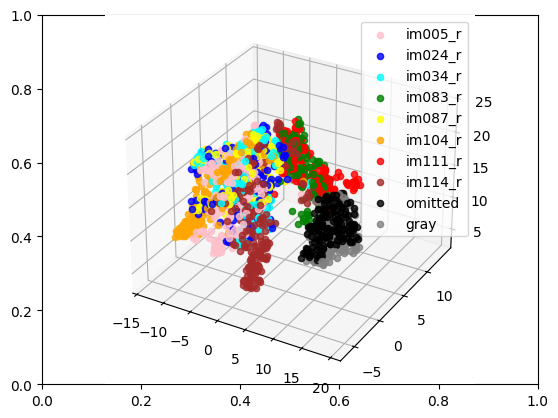

In [ ]:
umap_temp = umap.UMAP(n_neighbors=100, min_dist=2, spread=2, n_components=3, n_jobs=1, random_state=0)
u_transformed = umap_temp.fit_transform(u)

n_stimulus = 10
fig, ax = plt.subplots(1, 1)
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
for i in range(len(session_ids)):
        for j in range(n_iters):
            for k in range(n_stimulus):
                index = int(i * n_stimulus * n_iters + j * n_stimulus + k)
                ax1.scatter(u_transformed[index, 0], u_transformed[index, 1],u_transformed[index, 2], c=color[k], alpha=0.8)
plt.legend(imgs);
plt.show();

Things to try:
1. In similarity_redo, try incorporating the gray screens

### UMAP on neuro data for each state

In [6]:
def generate_contrasting_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        saturation = 1.0
        lightness = 0.5
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        colors.append(hex_color)
    return np.array(colors)

colors = generate_contrasting_colors(12)
shapes = np.array(['o', 's', 'p', 'P', '*', 'X', 'D', 'd', 'v', '^'])


In [ ]:
stimulus = behavior.stimulus_presentations
stimulus = stimulus[stimulus['stimulus_block'] == 0]
time_bins = np.arange(start_time, end_time, 0.05)
stimulus_names = np.zeros(len(time_bins), dtype=object)

stimulus_id = 0
time_id = 0

while stimulus_id < len(stimulus):
    stimulus_start_time = stimulus.iloc[stimulus_id]['start_time']
    stimulus_end_time = stimulus.iloc[stimulus_id]['end_time']
    # In stimulus
    # Allowing each bin to shift by 20%
    counter = 0
    while (True):
        if (((time_bins[time_id] + 0.05 * 0.49) >= stimulus_start_time) and ((time_bins[time_id] + 0.05 * 0.51) <= stimulus_end_time)):
            stimulus_names[time_id] = stimulus.iloc[stimulus_id]['image_name']
            time_id += 1
            counter += 1
            if time_id == len(time_bins):
                break

        else:
            if counter == 0:
                print("No actions taken: " + str(stimulus_id) + " " + str(time_id))
                print("Time: " + str(time_bins[time_id]))
                print("Stimulus start: " + str(stimulus_start_time))
                print("Stimulus end: " + str(stimulus_end_time))
                print("Shifted start: " + str(time_bins[time_id] + 0.05 * 0.49))
                print("Shifted end: " + str(time_bins[time_id] + 0.05 * 0.51))
                print("If gray: " + str(time_bins[time_id] + 0.05 * 0.50))
            break
    # Now out of stimulus
    stimulus_id += 1

    if time_id == len(time_bins):
        break

    if stimulus_id == len(stimulus):
        break

    stimulus_start_time = stimulus.iloc[stimulus_id]['start_time']
    stimulus_end_time = stimulus.iloc[stimulus_id]['end_time']

    # Gray areas
    # Allowing each bin to shift by 30%
    while (True):
        bin_time = time_bins[time_id] + 0.05 * 0.50
        if (bin_time <= stimulus_start_time):
            stimulus_names[time_id] = 'gray'
            time_id += 1
        else:
            break
        if time_id == len(time_bins):
            break

      |
    |3|-7-|

      |
  |-7-|3|

In [ ]:
display(stimulus[0:30])

In [72]:
print(stimulus_names)

['im104_r' 'im104_r' 'im104_r' ... 'omitted' 'omitted' 0]


In [12]:
path = "C:/Users/jerry/Downloads/train2_2/1055403683_0.npz"
a = np.load(path, allow_pickle=True)
preds = a['preds']

In [13]:
def normalize(data):
    data = np.array(data)
    data = data / (np.sum(data, axis=1, keepdims=True)+1e-10)
    return data

In [14]:
def zscore(data):
    data = np.array(data)
    data = (data - np.mean(data, axis=0, keepdims=True)) / (np.std(data, axis=0, keepdims=True)+1e-10)
    return data

In [9]:
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']
bin_size = 50
X = getX(start_time,end_time,bin_size).T
X_norm = zscore(X)
"""model = hmm.PoissonHMM(n_components=10, n_iter=1000, tol=10, verbose=True)
model.fit(X)
preds = model.predict(X)""";



100%|██████████| 38/38 [00:00<00:00, 61.53it/s]


In [10]:
print(X_norm[0])

[-4.97248576e-01 -7.57679634e-02 -6.59522763e-01 -8.00903453e-01
 -8.49257616e-02  9.74092690e-01 -6.05496109e-01 -2.44175780e-01
 -5.20382141e-01 -5.46275295e-01  2.25475910e-03 -7.38196117e-01
 -1.34155663e-01 -2.78473242e-01 -5.80553965e-02 -2.23706712e-01
 -9.95943492e-01 -3.17959174e-01 -2.68445260e-01 -7.68578796e-01
 -8.77084679e-02 -7.35082722e-01 -2.36188005e-01 -3.41443856e-01
 -1.72031321e-01 -2.32236930e-01 -3.32248368e-01 -2.25916012e-01
 -2.75124436e-01 -1.80962731e-01 -7.05039319e-02  5.55148050e-01
  2.72503366e+00 -5.02532445e-01  1.20686588e+00 -1.90629208e-01
 -5.94812345e-01 -7.44953243e-01]


In [21]:
X_decomp = umap.UMAP(n_neighbors=100, min_dist=1, spread=1, n_components=3, n_jobs=-1).fit_transform(X_norm)

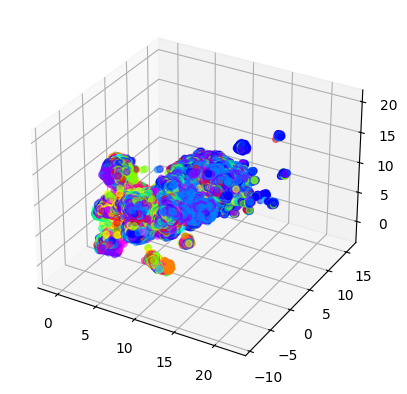

In [23]:
# n_neighbors=100, min_dist=1, spread=1, n_components=3, n_jobs=-1
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'});
ax.scatter(X_decomp[:,0], X_decomp[:,1], X_decomp[:,2], c=colors[preds],alpha=0.5);

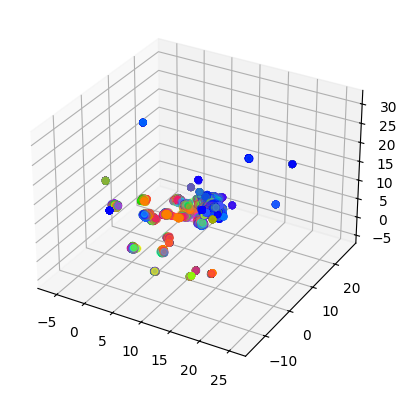

In [20]:
# n_neighbors=100, min_dist=0.1, spread=1, n_components=3, n_jobs=-1
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'});
ax.scatter(X_decomp[:,0], X_decomp[:,1], X_decomp[:,2], c=colors[preds],alpha=0.3);

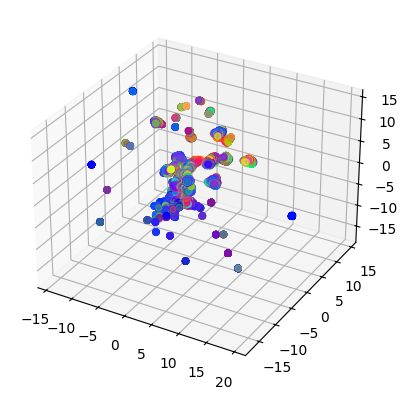

In [17]:
# n_neighbors=30, min_dist=0.1, spread=1, n_components=3, n_jobs=-1
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'});
ax.scatter(X_decomp[:,0], X_decomp[:,1], X_decomp[:,2], c=colors[preds],alpha=0.3);

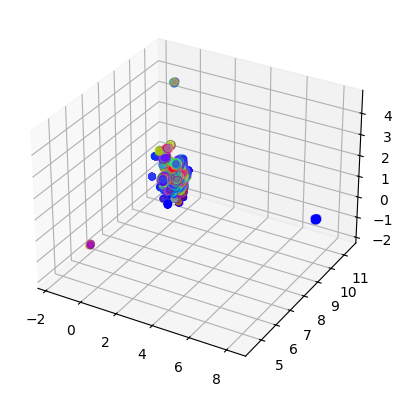

In [15]:
# n_neighbors=30, min_dist=0.1, spread=0.1, n_components=3, n_jobs=-1
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'});
ax.scatter(X_decomp[:,0], X_decomp[:,1], X_decomp[:,2], c=colors[preds],alpha=0.3);

In [135]:
def get_X_dynamic(start, stop, bin_size, sp, unit_idx):
    if (stop < 0 or start < 0): return -1
    bin_size = bin_size / 1000 # convert to mS
    sp = sp[(sp['start_time'] >= start) & (sp['end_time'] <= stop)]
    stim_idx = np.array(list(sp.index))
    stim_idx = list(sp.index)
    # For every unit
    for idx, unit in tqdm(enumerate(unit_idx)):
        x_unit = np.zeros(1) # Used as the base for hstack for each unit
        spikes = np.array(spike_times[unit])
        for jdx, stim in enumerate(stim_idx):
            stim_start = sp.iloc[jdx]['start_time']
            stim_end = sp.iloc[jdx]['end_time']
            duration = stim_end - stim_start
            n_bin = round(duration / 0.05)
            hist = np.histogram(spikes, bins=n_bin, range=(stim_start, stim_end))[0]
            x_unit = np.hstack((x_unit, hist))
            # Now considering the gray areas
            if jdx != len(stim_idx) - 1:
                gray_start = stim_end
                gray_end = sp.iloc[jdx+1]['start_time']
                duration = gray_end - gray_start
                n_bin = round(duration / 0.05)
                hist = np.histogram(spikes, bins=n_bin, range=(gray_start, gray_end))[0]
                x_unit = np.hstack((x_unit, hist))
        x_unit = x_unit[1:]
        if idx == 0: # This is the first entry, used as the base for vstack
            X = copy.deepcopy(x_unit)
        else:
            X = np.vstack((X, x_unit))
    return X

In [136]:
start_time = sp.iloc[0]['start_time']
end_time = sp.iloc[-1]['end_time']

In [137]:
X_1 = get_X_dynamic(start_time, end_time, 50, sp, unit_channels_indices)

38it [02:52,  4.54s/it]


In [138]:
print(X_1.shape)

(38, 71990)


In [139]:
X = getX(start_time, end_time, 50)
print(X.shape)

100%|██████████| 38/38 [00:00<00:00, 66.76it/s]

(38, 72062)


In [123]:
spikes = np.array(spike_times[unit_channels_indices[0]])


In [124]:
stim = 0
stim_start = sp.iloc[stim]['start_time']
stim_end = sp.iloc[stim]['end_time']
duration = stim_end - stim_start
n_bin = round(duration / 0.05)
spikes_in_stim = spikes[np.array((spikes >= stim_start) & (spikes <= stim_end))]
hist = np.histogram(spikes_in_stim, bins=n_bin)
print(hist)

(array([0, 0, 0, 0, 0], dtype=int64), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))


In [126]:
stim = 0
stim_start = sp.iloc[stim]['start_time']
stim_end = sp.iloc[stim]['end_time']
duration = stim_end - stim_start
n_bin = round(duration / 0.05)
hist2 = np.histogram(spikes_in_stim, bins=n_bin, range=(stim_start, stim_end))
print(hist2)

(array([0, 0, 0, 0, 0], dtype=int64), array([25.49450032, 25.54454382, 25.59458732, 25.64463083, 25.69467433,
       25.74471783]))


In [119]:
arr = [1,2,100,1000,10000]
print(np.histogram(arr, bins=2, range=(0,1000)))

(array([3, 1], dtype=int64), array([   0.,  500., 1000.]))


In [54]:
test_ids = unit_channels_indices[0:10]

In [111]:
r_spikes = np.array(spike_times[test_ids[0]])
print(r_spikes[150:160])
range = np.array((r_spikes >= stim_start) & (r_spikes <= stim_end))
print(np.where(range==True))

[24.39958453 24.61648461 24.79018467 24.8772847  24.90998471 25.36625153
 25.44771822 25.82765168 26.39805188 26.54675193]
(array([], dtype=int64),)


In [116]:
spikes = np.array(r_spikes)[np.array((r_spikes >= stim_start) & (r_spikes <= stim_end))]
print(np.histogram(spikes, bins=5)[0])

[0 0 0 0 0]


In [120]:
start = sp.iloc[0]['start_time']
stop = sp.iloc[-1]['end_time']
print(start)
print(stop)

25.494500322412584
3628.607341823703


In [57]:
for id in test_ids:
    print(len(spike_times[id]))

88992
5197
119686
72980
16153
61244
50267
15314
32826
34978


In [35]:
i = 2
xarr = np.zeros([i,1]) 
print(xarr)
xarr = np.hstack((xarr, [[1],[2]]))
print(xarr)
xarr = np.delete(xarr, 0, 1)
print(xarr)

[[0.]
 [0.]]
[[0. 1.]
 [0. 2.]]
[[1.]
 [2.]]


In [ ]:
def getX(start, stop, bin_size):
    if (stop < 0 or start < 0): return -1
    time = stop - start
    bin_count = int(time * 1000 / bin_size)
    X = np.zeros(bin_count)
    for unit in tqdm(unit_channels_indices):
        # Dividing epochs
        raw_spikes = spike_times[unit]
        bins = np.linspace(start,stop,num=bin_count+1)
        x_1 = np.histogram(raw_spikes, bins=bins)[0].tolist()
        #x_1 = np.array(stats.zscore(x_1))
        X = np.vstack((X, x_1))
    X = np.delete(X, 0, 0)
    return X